In [1]:
# ==== Core ====
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import re
# ==== Viz ====
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from IPython.display import display

# ==== Stats / Transforms ====
from scipy.special import boxcox1p
from mplfinance.original_flavor import candlestick_ohlc

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, LabelEncoder,
    StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.neighbors import NearestNeighbors
import optuna


ModuleNotFoundError: No module named 'optuna'

In [2]:
import matplotlib
matplotlib.rc('font', family='NanumGothic')  # 또는 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
os.chdir(r'/workspace/project/upstage-ml-regression-sigma7/data')

In [4]:
# load data
train_file = r'raw/train.csv'
test_file = r'raw/test.csv'
train = pd.read_csv(train_file, encoding= 'utf-8')
test = pd.read_csv(test_file, encoding= 'utf-8')
bus = pd.read_csv('raw/bus_feature.csv', encoding= 'utf-8')
subway = pd.read_csv('raw/subway_feature.csv', encoding= 'utf-8')
print('train 데이터입니다.')
train

train 데이터입니다.


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000


In [6]:
train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [7]:
train.isnull().sum().sort_values(ascending=True)

시군구                             0
중개사소재지                          0
거래유형                            0
등기신청일자                          0
도로명                             0
건축년도                            0
층                               0
target                          0
계약년월                            0
전용면적(㎡)                         0
계약일                             0
부번                             75
본번                             75
번지                            225
아파트명                         2126
k-관리비부과면적                  869563
k-전체세대수                    869563
k-난방방식                     869563
k-관리방식                     869563
k-연면적                      869563
기타/의무/임대/임의=1/2/3/4        869563
사용허가여부                     869563
관리비 업로드                    869563
k-세대타입(분양형태)               869563
k-85㎡~135㎡이하               869608
k-전용면적별세대현황(60㎡~85㎡이하)     869608
k-전용면적별세대현황(60㎡이하)         869608
k-수정일자                     869608
k-주거전용면적                   869608
단지신청일         

In [8]:
a = train['k-85㎡~135㎡이하'].notnull().sum()
b = train['k-135㎡초과'].notnull().sum()
c = train['k-전용면적별세대현황(60㎡~85㎡이하)'].notnull().sum()
d = train['k-전용면적별세대현황(60㎡이하)'].notnull().sum()

total = a + b + c + d
print("총 개수:", total)

총 개수: 747969


In [9]:
train['is_test'] = 1
test['is_test'] = 0

train = pd.concat([train, test])

In [10]:

# 1) 면적대 컬럼 이름
area_cols = [
    'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)',
    'k-85㎡~135㎡이하',
    'k-135㎡초과'
]

# 2) train(=train+test concat) 한 방에 처리: 플래그 + 대표면적 범주(main_area_type)
def add_area_features_inplace(df: pd.DataFrame) -> None:
    # (a) 4개 모두 결측 플래그
    df['area_all_missing'] = df[area_cols].isna().all(axis=1).astype(int)

    # (b) 비율 계산용으로 결측을 0으로 간주
    vals = df[area_cols].fillna(0)

    # (c) 합계
    total = vals.sum(axis=1)

    # (d) 합계가 0이면 비율 0, 아니면 각 구간/합계
    ratio = pd.DataFrame(
        np.where(total.values[:, None] == 0, 0, vals.values / total.values[:, None]),
        columns=area_cols,
        index=df.index
    )

    # (e) 가장 큰 비율의 컬럼명
    main_col = ratio.idxmax(axis=1)

    # (f) 컬럼명 → 라벨 매핑(1~4)
    mapping = {
        'k-전용면적별세대현황(60㎡이하)': 1,
        'k-전용면적별세대현황(60㎡~85㎡이하)': 2,
        'k-85㎡~135㎡이하': 3,
        'k-135㎡초과': 4
    }
    df['main_area_type'] = main_col.map(mapping)

    # (g) 라벨 없음 조건: 합계==0 또는 4개 모두 결측
    mask_no_label = (total == 0) | (df['area_all_missing'] == 1)
    df.loc[mask_no_label, 'main_area_type'] = np.nan

    # (h) 범주형 dtype으로 고정(1~4만 허용)
    df['main_area_type'] = pd.Categorical(df['main_area_type'], categories=[1,2,3,4])

# 3) 실제 적용 (train 하나에 바로 추가)
add_area_features_inplace(train)

# 4) LightGBM에 넘길 때(예시):
# - categorical_feature에는 'main_area_type'만 넣고
# - 'area_all_missing'은 0/1 수치 피처로 그대로 사용
categorical_cols = ['main_area_type']
for c in categorical_cols:
    train[c] = train[c].astype('category')

# cat_idx가 필요하면 (DataFrame 기준 인덱스)
cat_idx = [train.columns.get_loc(c) for c in categorical_cols]

In [11]:
train['area_all_missing'].value_counts()

1    876170
0    251924
Name: area_all_missing, dtype: int64

In [12]:
# 범주형 변수 처리 구분
categorical_cols

['main_area_type']

In [13]:
train.drop(area_cols, axis=1, inplace=True)

In [14]:
train

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,area_all_missing,main_area_type
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,1,0,2
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,1,0,2
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,1,0,2
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,1,0,2
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,0,0,1
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,0,0,1
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,0,0,1
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,0,0,1


In [15]:
drop_cols = [
    'k-관리비부과면적',
    'k-전체세대수',
    'k-난방방식',
    'k-관리방식',
    'k-연면적',
    '기타/의무/임대/임의=1/2/3/4',
    '사용허가여부',
    '관리비 업로드',
    'k-세대타입(분양형태)',
]

# 컬럼 삭제
train = train.drop(columns=drop_cols)

In [16]:
train.isnull().sum().sort_values(ascending=False)

해제사유발생일               1121899
k-등록일자                1116386
단지소개기존clob            1058958
k-홈페이지                1013523
고용보험관리번호               920757
세대전기계약방법               885389
k-팩스번호                 879348
k-시행사                  877834
청소비관리형태                877751
k-건설사(시공사)             877637
main_area_type         877611
경비비관리형태                877561
k-단지분류(아파트,주상복합등등)     877273
k-전체동수                 877207
단지승인일                  876854
k-전화번호                 876850
k-복도유형                 876454
건축면적                   876279
주차대수                   876277
k-사용검사일-사용승인일          876259
좌표X                    876232
좌표Y                    876232
단지신청일                  876187
k-주거전용면적               876170
k-수정일자                 876170
target                   9272
아파트명                     2136
번지                        227
부번                         75
본번                         75
is_test                     0
area_all_missing            0
도로명                         0
전용면적(㎡)   

In [17]:
train.drop(['k-등록일자','해제사유발생일','단지소개기존clob','k-홈페이지','고용보험관리번호','k-팩스번호','세대전기계약방법','k-시행사',
'청소비관리형태','k-건설사(시공사)','경비비관리형태',
'k-전체동수','단지승인일','k-전화번호','k-복도유형','건축면적','주차대수','k-사용검사일-사용승인일','단지신청일','k-주거전용면적'
,'k-수정일자'],axis=1, inplace=True)

In [18]:
train.isnull().sum().sort_values(ascending=False)

main_area_type        877611
k-단지분류(아파트,주상복합등등)    877273
좌표Y                   876232
좌표X                   876232
target                  9272
아파트명                    2136
번지                       227
본번                        75
부번                        75
중개사소재지                     0
area_all_missing           0
is_test                    0
시군구                        0
거래유형                       0
등기신청일자                     0
건축년도                       0
층                          0
계약일                        0
계약년월                       0
전용면적(㎡)                    0
도로명                        0
dtype: int64

In [19]:
train.drop(['k-단지분류(아파트,주상복합등등)'],axis= 1 , inplace = True)

In [20]:
train['층'].value_counts()

 5     82748
 4     82633
 3     81089
 2     77575
 6     74215
       ...  
 68        6
 65        6
 67        6
-4         4
 69        2
Name: 층, Length: 73, dtype: int64

In [21]:
# 남길 컬럼 리스트 정의
keep_cols = [
    '시군구',  '등기신청일자', '도로명',
    '건축년도', '층', '계약년월', '전용면적(㎡)',
    '계약일', '부번', '본번', '번지', '아파트명','area_all_missing','main_area_type','is_test','target','좌표X','좌표Y'
]

# 해당 컬럼만 남기기
train = train[keep_cols]


In [22]:
train.isnull().sum()

시군구                      0
등기신청일자                   0
도로명                      0
건축년도                     0
층                        0
계약년월                     0
전용면적(㎡)                  0
계약일                      0
부번                      75
본번                      75
번지                     227
아파트명                  2136
area_all_missing         0
main_area_type      877611
is_test                  0
target                9272
좌표X                 876232
좌표Y                 876232
dtype: int64

In [23]:
train = train.loc[:, ~train.columns.duplicated()]

In [24]:
train.drop('등기신청일자',axis=1 ,inplace=True)

In [25]:
train['도로명'].value_counts()

올림픽로 435      4372
솔샘로 174       4049
송파대로 345      3668
성북로4길 52      3519
양재대로 1340     3369
              ... 
한강대로62길 18       1
광나루로39길 11       1
 20-3            1
곰달래로 60-1        1
을지로15길 31        1
Name: 도로명, Length: 9245, dtype: int64

In [26]:
# 좋은_도로 피처만 추가하는 간단한 코드

# 1. 프리미엄 도로 리스트
premium_roads = ['강남대로', '테헤란로', '도산대로', '논현로', '압구정로', '봉은사로', 
                '언주로', '반포대로', '서초대로', '잠실로', '올림픽로', '한강대로', 
                '여의대로', '을지로', '종로', '세종대로', '퇴계로', '소공로', '명동길']

# 2. 주요 도로 리스트 (확장)
major_roads_extended = [
    # 강남권 추가
    '선릉로', '역삼로', '학동로', '신사역로', '압구정역로', '청담로', '삼성로',
    '영동대로', '선릉역로', '개포로', '일원로', '수서로',
    
    # 서초/반포 추가  
    '방배로', '사평대로', '동작대로', '현충로', '서래로',
    
    # 송파/잠실 추가
    '백제고분로', '송파대로', '양재대로', '가락로', '문정로',
    
    # 여의도/마포 추가
    '마포대로', '양화로', '서강대로', '홍익로', '합정로',
    
    # 강북 주요 도로
    '동호로', '장충단로', '충무로', '명륜길', '대학로', '성균관로',
    '창경궁로', '돈화문로', '인사동길', '삼일대로', '청계천로',
    
    # 용산/이태원
    '이태원로', '한남대로', '보광로', '소월로',
    
    # 영등포/구로
    '영등포로', '당산로', '선유로', '경인로',
    
    # 기타 주요 간선도로
    '강변북로', '내부순환로', '외곽순환고속도로', '경부고속도로'
]

# 3. 전체 좋은 도로 리스트 (프리미엄 + 주요)
all_good_roads = premium_roads + major_roads_extended

# 4. 도로명 컬럼 (실제 컬럼명으로 수정 필요)
road_column = '도로명'  # '도로명주소', '주소' 등으로 변경

# 5. 좋은_도로 피처 생성
print("좋은_도로 피처 생성 중...")
train['좋은_도로'] = train[road_column].astype(str).str.contains(
    '|'.join(all_good_roads), na=False
).astype(int)

# 6. 결과 확인
total_count = len(train)
good_road_count = train['좋은_도로'].sum()
good_road_ratio = good_road_count / total_count

print(f"\n=== 좋은_도로 피처 생성 완료 ===")
print(f"전체 데이터: {total_count:,}개")
print(f"좋은_도로 = 1: {good_road_count:,}개 ({good_road_ratio:.1%})")
print(f"좋은_도로 = 0: {total_count - good_road_count:,}개 ({1-good_road_ratio:.1%})")

# 7. 데이터 타입 확인
print(f"\n피처 정보:")
print(f"- 컬럼명: 좋은_도로")
print(f"- 데이터 타입: {train['좋은_도로'].dtype}")
print(f"- 값 분포: {dict(train['좋은_도로'].value_counts().sort_index())}")

print("\n✅ '좋은_도로' 피처가 성공적으로 추가되었습니다!")
print("   이제 모델 학습에 사용할 수 있습니다.")

좋은_도로 피처 생성 중...

=== 좋은_도로 피처 생성 완료 ===
전체 데이터: 1,128,094개
좋은_도로 = 1: 168,063개 (14.9%)
좋은_도로 = 0: 960,031개 (85.1%)

피처 정보:
- 컬럼명: 좋은_도로
- 데이터 타입: int64
- 값 분포: {0: 960031, 1: 168063}

✅ '좋은_도로' 피처가 성공적으로 추가되었습니다!
   이제 모델 학습에 사용할 수 있습니다.


In [27]:
train

,시군구,도로명,건축년도,층,계약년월,전용면적(㎡),계약일,부번,본번,번지,아파트명,area_all_missing,main_area_type,is_test,target,좌표X,좌표Y,좋은_도로
0,서울특별시 강남구 개포동,언주로 3,1987,3,201712,79.97,8,1.0,658.0,658-1,개포6차우성,0,2,1,124000.0,127.05721,37.476763,1
1,서울특별시 강남구 개포동,언주로 3,1987,4,201712,79.97,22,1.0,658.0,658-1,개포6차우성,0,2,1,123500.0,127.05721,37.476763,1
2,서울특별시 강남구 개포동,언주로 3,1987,5,201712,54.98,28,1.0,658.0,658-1,개포6차우성,0,2,1,91500.0,127.05721,37.476763,1
3,서울특별시 강남구 개포동,언주로 3,1987,4,201801,79.97,3,1.0,658.0,658-1,개포6차우성,0,2,1,130000.0,127.05721,37.476763,1
4,서울특별시 강남구 개포동,언주로 3,1987,2,201801,79.97,8,1.0,658.0,658-1,개포6차우성,0,2,1,117000.0,127.05721,37.476763,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,신내역로1길 85,2014,13,202307,84.65,19,0.0,816.0,816,신내우디안1단지,0,1,0,NaN,127.10672,37.618870,0
9268,서울특별시 중랑구 신내동,신내역로1길 85,2014,12,202307,84.62,25,0.0,816.0,816,신내우디안1단지,0,1,0,NaN,127.10672,37.618870,0
9269,서울특별시 중랑구 신내동,신내역로1길 85,2014,12,202308,101.65,27,0.0,816.0,816,신내우디안1단지,0,1,0,NaN,127.10672,37.618870,0
9270,서울특별시 중랑구 신내동,신내역로1길 85,2014,18,202309,84.94,2,0.0,816.0,816,신내우디안1단지,0,1,0,NaN,127.10672,37.618870,0


In [28]:
# 아파트 브랜드 등급 변수 생성
import re
import pandas as pd

# === 1) 우선순위 패턴 목록 (위에서 아래로 매칭) ===
# (정규식 패턴, 등급)
PATTERN_GRADED = [

    # ---- 5등급: 최상위 랜드마크/초고가 ----
    (r'한남더힐', 5),
    (r'나인원\s*한남|Nine\s*One\s*Hannam', 5),
    (r'PH\s*129|PH129', 5),
    (r'아크로\s*서울\s*포레스트|Acro\s*Seoul\s*Forest', 5),
    (r'아크로\s*리버\s*파크|Acro\s*River\s*Park', 5),

    # ---- 4등급: 강남권 최상위/프리미엄 플래그십 ----
    (r'원\s*베일리|원베일리|래미안\s*원\s*베일리', 4),
    (r'반포\s*자이', 4),
    (r'래미안\s*퍼스티지', 4),
    (r'압구정.*현대|현대.*압구정', 4),
    (r'디\s*에이치|THE\s*H|The\s*H', 4),             # 현대 고급 브랜드 (예: 디에이치 아너힐즈 등)
    (r'트리마제|Trimage', 4),
    (r'라클래시|래미안\s*라\s*클래시|Raemian\s*Laclass', 4),

    # ---- 3등급: 메이저 브랜드 일반/강남권 대단지 ----
    (r'래미안|Raemian', 3),
    (r'자이|Xi\b', 3),
    (r'아이\s*파크|I-?PARK|IPARK', 3),
    (r'푸르지오|Prugio', 3),
    (r'더\s*샵|The\s*Sharp', 3),
    (r'e\s*편한\s*세상|e편한세상|e-?Pyeonhansesang', 3),
    (r'센트레빌', 3),
    (r'래대푸|마포\s*래미안\s*푸르지오', 3),
    (r'헬리오\s*시티|Helio\s*City', 3),
    (r'파크리오', 3),
    (r'올림픽\s*선수촌', 3),
    (r'잠실\s*(리센츠|엘스|트리지움)', 3),

    # ---- 2등급: 준메이저/중상 브랜드, 대중적 신축/재건축 ----
    (r'힐스테이트|Hillstate', 2),
    (r'롯데\s*캐슬|Lotte\s*Castle', 2),
    (r'위브|We\'?ve', 2),
    (r'호반\s*(써밋|베르디움)', 2),
    (r'경남\s*아너스빌|아너스빌', 2),
    (r'두산', 2),
    (r'금호', 2),
    (r'벽산', 2),
    (r'현대\s*홈\s*타운', 2),

    # ---- 1등급: 기타/브랜드 미표기/중소 ----
    # 매칭 없으면 1로 처리
]

def brand_grade_from_name(name: str) -> int:
    """아파트명 문자열에서 브랜드/단지 키워드를 정규식으로 찾아 5~1등급 반환."""
    if pd.isna(name):
        return 1
    s = str(name).strip()
    # 공백/하이픈/대소문자 변형 허용을 위한 전처리(선택): 여기서는 정규식이 유연해서 생략 가능
    for pattern, grade in PATTERN_GRADED:
        if re.search(pattern, s, flags=re.IGNORECASE):
            return int(grade)
    return 1

# 사용 예시
train['apt_grade'] = train['아파트명'].apply(brand_grade_from_name).astype(int)

In [29]:
# apt_grade 1~5 -> 1,2,3(보통),3(보통),3(보통) 으로 변환
bins_map_A = {1:1, 2:2, 3:3, 4:3, 5:3}
train['아파트_등급'] =train['apt_grade'].map(bins_map_A).astype('Int64')

train['프리미엄_아파트'] =train['apt_grade'].isin([4,5]).astype(int)
# apt_grade 자체(1~5) + is_ultra_premium(0/1) 병행

In [30]:
train

,시군구,도로명,건축년도,층,계약년월,전용면적(㎡),계약일,부번,본번,번지,...,area_all_missing,main_area_type,is_test,target,좌표X,좌표Y,좋은_도로,apt_grade,아파트_등급,프리미엄_아파트
0,서울특별시 강남구 개포동,언주로 3,1987,3,201712,79.97,8,1.0,658.0,658-1,...,0,2,1,124000.0,127.05721,37.476763,1,1,1,0
1,서울특별시 강남구 개포동,언주로 3,1987,4,201712,79.97,22,1.0,658.0,658-1,...,0,2,1,123500.0,127.05721,37.476763,1,1,1,0
2,서울특별시 강남구 개포동,언주로 3,1987,5,201712,54.98,28,1.0,658.0,658-1,...,0,2,1,91500.0,127.05721,37.476763,1,1,1,0
3,서울특별시 강남구 개포동,언주로 3,1987,4,201801,79.97,3,1.0,658.0,658-1,...,0,2,1,130000.0,127.05721,37.476763,1,1,1,0
4,서울특별시 강남구 개포동,언주로 3,1987,2,201801,79.97,8,1.0,658.0,658-1,...,0,2,1,117000.0,127.05721,37.476763,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,신내역로1길 85,2014,13,202307,84.65,19,0.0,816.0,816,...,0,1,0,NaN,127.10672,37.618870,0,1,1,0
9268,서울특별시 중랑구 신내동,신내역로1길 85,2014,12,202307,84.62,25,0.0,816.0,816,...,0,1,0,NaN,127.10672,37.618870,0,1,1,0
9269,서울특별시 중랑구 신내동,신내역로1길 85,2014,12,202308,101.65,27,0.0,816.0,816,...,0,1,0,NaN,127.10672,37.618870,0,1,1,0
9270,서울특별시 중랑구 신내동,신내역로1길 85,2014,18,202309,84.94,2,0.0,816.0,816,...,0,1,0,NaN,127.10672,37.618870,0,1,1,0


In [31]:
# 아파트명 변수 제거
train.drop('apt_grade',axis=1, inplace=True)

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   시군구               1128094 non-null  object  
 1   도로명               1128094 non-null  object  
 2   건축년도              1128094 non-null  int64   
 3   층                 1128094 non-null  int64   
 4   계약년월              1128094 non-null  int64   
 5   전용면적(㎡)           1128094 non-null  float64 
 6   계약일               1128094 non-null  int64   
 7   부번                1128019 non-null  float64 
 8   본번                1128019 non-null  float64 
 9   번지                1127867 non-null  object  
 10  아파트명              1125958 non-null  object  
 11  area_all_missing  1128094 non-null  int64   
 12  main_area_type    250483 non-null   category
 13  is_test           1128094 non-null  int64   
 14  target            1118822 non-null  float64 
 15  좌표X               251862 non-null  

In [33]:
train['구'] =train['시군구'].apply(lambda x: str(x).split(' ')[1] if len(str(x).split(' ')) > 1 else '기타')
train['동'] =train['시군구'].apply(lambda x: str(x).split(' ')[2] if len(str(x).split(' ')) > 2 else '기타')
train.drop('시군구', axis=1, inplace=True)

In [34]:
train

,도로명,건축년도,층,계약년월,전용면적(㎡),계약일,부번,본번,번지,아파트명,...,main_area_type,is_test,target,좌표X,좌표Y,좋은_도로,아파트_등급,프리미엄_아파트,구,동
0,언주로 3,1987,3,201712,79.97,8,1.0,658.0,658-1,개포6차우성,...,2,1,124000.0,127.05721,37.476763,1,1,0,강남구,개포동
1,언주로 3,1987,4,201712,79.97,22,1.0,658.0,658-1,개포6차우성,...,2,1,123500.0,127.05721,37.476763,1,1,0,강남구,개포동
2,언주로 3,1987,5,201712,54.98,28,1.0,658.0,658-1,개포6차우성,...,2,1,91500.0,127.05721,37.476763,1,1,0,강남구,개포동
3,언주로 3,1987,4,201801,79.97,3,1.0,658.0,658-1,개포6차우성,...,2,1,130000.0,127.05721,37.476763,1,1,0,강남구,개포동
4,언주로 3,1987,2,201801,79.97,8,1.0,658.0,658-1,개포6차우성,...,2,1,117000.0,127.05721,37.476763,1,1,0,강남구,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,202307,84.65,19,0.0,816.0,816,신내우디안1단지,...,1,0,NaN,127.10672,37.618870,0,1,0,중랑구,신내동
9268,신내역로1길 85,2014,12,202307,84.62,25,0.0,816.0,816,신내우디안1단지,...,1,0,NaN,127.10672,37.618870,0,1,0,중랑구,신내동
9269,신내역로1길 85,2014,12,202308,101.65,27,0.0,816.0,816,신내우디안1단지,...,1,0,NaN,127.10672,37.618870,0,1,0,중랑구,신내동
9270,신내역로1길 85,2014,18,202309,84.94,2,0.0,816.0,816,신내우디안1단지,...,1,0,NaN,127.10672,37.618870,0,1,0,중랑구,신내동


In [35]:
# 서울 집값 등급 변수 생성
price_group = {
    "강남구": 3, "서초구": 3, "송파구": 3, "용산구": 3,
    "마포구": 2, "성동구": 2, "광진구": 2, "동작구": 2, "양천구": 2, "강동구": 2,
}
train["서울집값등급"] = train["구"].map(price_group).fillna(1)

In [36]:
categorical_cols

['main_area_type']

In [37]:
categorical_cols.append('구')
categorical_cols.append('동')

In [38]:
train

,도로명,건축년도,층,계약년월,전용면적(㎡),계약일,부번,본번,번지,아파트명,...,is_test,target,좌표X,좌표Y,좋은_도로,아파트_등급,프리미엄_아파트,구,동,서울집값등급
0,언주로 3,1987,3,201712,79.97,8,1.0,658.0,658-1,개포6차우성,...,1,124000.0,127.05721,37.476763,1,1,0,강남구,개포동,3.0
1,언주로 3,1987,4,201712,79.97,22,1.0,658.0,658-1,개포6차우성,...,1,123500.0,127.05721,37.476763,1,1,0,강남구,개포동,3.0
2,언주로 3,1987,5,201712,54.98,28,1.0,658.0,658-1,개포6차우성,...,1,91500.0,127.05721,37.476763,1,1,0,강남구,개포동,3.0
3,언주로 3,1987,4,201801,79.97,3,1.0,658.0,658-1,개포6차우성,...,1,130000.0,127.05721,37.476763,1,1,0,강남구,개포동,3.0
4,언주로 3,1987,2,201801,79.97,8,1.0,658.0,658-1,개포6차우성,...,1,117000.0,127.05721,37.476763,1,1,0,강남구,개포동,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,202307,84.65,19,0.0,816.0,816,신내우디안1단지,...,0,NaN,127.10672,37.618870,0,1,0,중랑구,신내동,1.0
9268,신내역로1길 85,2014,12,202307,84.62,25,0.0,816.0,816,신내우디안1단지,...,0,NaN,127.10672,37.618870,0,1,0,중랑구,신내동,1.0
9269,신내역로1길 85,2014,12,202308,101.65,27,0.0,816.0,816,신내우디안1단지,...,0,NaN,127.10672,37.618870,0,1,0,중랑구,신내동,1.0
9270,신내역로1길 85,2014,18,202309,84.94,2,0.0,816.0,816,신내우디안1단지,...,0,NaN,127.10672,37.618870,0,1,0,중랑구,신내동,1.0


In [39]:
train['서울집값등급'] = train['서울집값등급'].astype(int)

In [40]:
train['계약년월'] = pd.to_datetime(train['계약년월'], format='%Y%m' )

train['계약년'] = train['계약년월'].dt.year


In [42]:
train.drop('계약년월', axis=1, inplace=True)

In [44]:
train

,도로명,건축년도,층,전용면적(㎡),계약일,부번,본번,번지,아파트명,area_all_missing,...,target,좌표X,좌표Y,좋은_도로,아파트_등급,프리미엄_아파트,구,동,서울집값등급,계약년
0,언주로 3,1987,3,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,124000.0,127.05721,37.476763,1,1,0,강남구,개포동,3,2017
1,언주로 3,1987,4,79.97,22,1.0,658.0,658-1,개포6차우성,0,...,123500.0,127.05721,37.476763,1,1,0,강남구,개포동,3,2017
2,언주로 3,1987,5,54.98,28,1.0,658.0,658-1,개포6차우성,0,...,91500.0,127.05721,37.476763,1,1,0,강남구,개포동,3,2017
3,언주로 3,1987,4,79.97,3,1.0,658.0,658-1,개포6차우성,0,...,130000.0,127.05721,37.476763,1,1,0,강남구,개포동,3,2018
4,언주로 3,1987,2,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,117000.0,127.05721,37.476763,1,1,0,강남구,개포동,3,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,84.65,19,0.0,816.0,816,신내우디안1단지,0,...,NaN,127.10672,37.618870,0,1,0,중랑구,신내동,1,2023
9268,신내역로1길 85,2014,12,84.62,25,0.0,816.0,816,신내우디안1단지,0,...,NaN,127.10672,37.618870,0,1,0,중랑구,신내동,1,2023
9269,신내역로1길 85,2014,12,101.65,27,0.0,816.0,816,신내우디안1단지,0,...,NaN,127.10672,37.618870,0,1,0,중랑구,신내동,1,2023
9270,신내역로1길 85,2014,18,84.94,2,0.0,816.0,816,신내우디안1단지,0,...,NaN,127.10672,37.618870,0,1,0,중랑구,신내동,1,2023


In [45]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12584 entries, 0 to 12583
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   노드 ID   12584 non-null  int64  
 1   정류소번호   12584 non-null  int64  
 2   정류소명    12584 non-null  object 
 3   X좌표     12584 non-null  float64
 4   Y좌표     12584 non-null  float64
 5   정류소 타입  12584 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 590.0+ KB


In [46]:
bus.columns = ['노드ID', '정류소번호', '정류소명', '경도', '위도', '정류소 타입' ]

In [47]:
# 좌표 변수 제거
train['경도'] =  train['좌표X']
train['위도'] =  train['좌표Y']
train.drop(['좌표X','좌표Y'], axis=1, inplace=True)

In [48]:
train

,도로명,건축년도,층,전용면적(㎡),계약일,부번,본번,번지,아파트명,area_all_missing,...,target,좋은_도로,아파트_등급,프리미엄_아파트,구,동,서울집값등급,계약년,경도,위도
0,언주로 3,1987,3,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,124000.0,1,1,0,강남구,개포동,3,2017,127.05721,37.476763
1,언주로 3,1987,4,79.97,22,1.0,658.0,658-1,개포6차우성,0,...,123500.0,1,1,0,강남구,개포동,3,2017,127.05721,37.476763
2,언주로 3,1987,5,54.98,28,1.0,658.0,658-1,개포6차우성,0,...,91500.0,1,1,0,강남구,개포동,3,2017,127.05721,37.476763
3,언주로 3,1987,4,79.97,3,1.0,658.0,658-1,개포6차우성,0,...,130000.0,1,1,0,강남구,개포동,3,2018,127.05721,37.476763
4,언주로 3,1987,2,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,117000.0,1,1,0,강남구,개포동,3,2018,127.05721,37.476763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,84.65,19,0.0,816.0,816,신내우디안1단지,0,...,NaN,0,1,0,중랑구,신내동,1,2023,127.10672,37.618870
9268,신내역로1길 85,2014,12,84.62,25,0.0,816.0,816,신내우디안1단지,0,...,NaN,0,1,0,중랑구,신내동,1,2023,127.10672,37.618870
9269,신내역로1길 85,2014,12,101.65,27,0.0,816.0,816,신내우디안1단지,0,...,NaN,0,1,0,중랑구,신내동,1,2023,127.10672,37.618870
9270,신내역로1길 85,2014,18,84.94,2,0.0,816.0,816,신내우디안1단지,0,...,NaN,0,1,0,중랑구,신내동,1,2023,127.10672,37.618870


In [49]:


train


,도로명,건축년도,층,전용면적(㎡),계약일,부번,본번,번지,아파트명,area_all_missing,...,target,좋은_도로,아파트_등급,프리미엄_아파트,구,동,서울집값등급,계약년,경도,위도
0,언주로 3,1987,3,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,124000.0,1,1,0,강남구,개포동,3,2017,127.05721,37.476763
1,언주로 3,1987,4,79.97,22,1.0,658.0,658-1,개포6차우성,0,...,123500.0,1,1,0,강남구,개포동,3,2017,127.05721,37.476763
2,언주로 3,1987,5,54.98,28,1.0,658.0,658-1,개포6차우성,0,...,91500.0,1,1,0,강남구,개포동,3,2017,127.05721,37.476763
3,언주로 3,1987,4,79.97,3,1.0,658.0,658-1,개포6차우성,0,...,130000.0,1,1,0,강남구,개포동,3,2018,127.05721,37.476763
4,언주로 3,1987,2,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,117000.0,1,1,0,강남구,개포동,3,2018,127.05721,37.476763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,84.65,19,0.0,816.0,816,신내우디안1단지,0,...,NaN,0,1,0,중랑구,신내동,1,2023,127.10672,37.618870
9268,신내역로1길 85,2014,12,84.62,25,0.0,816.0,816,신내우디안1단지,0,...,NaN,0,1,0,중랑구,신내동,1,2023,127.10672,37.618870
9269,신내역로1길 85,2014,12,101.65,27,0.0,816.0,816,신내우디안1단지,0,...,NaN,0,1,0,중랑구,신내동,1,2023,127.10672,37.618870
9270,신내역로1길 85,2014,18,84.94,2,0.0,816.0,816,신내우디안1단지,0,...,NaN,0,1,0,중랑구,신내동,1,2023,127.10672,37.618870


In [50]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# 1) 거리 계산 (Haversine) - km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

# 2) 버스/지하철 최근접 거리 계산 (좌표 있는 행만, 결과는 km)
def compute_min_dist(train_df: pd.DataFrame, poi_df: pd.DataFrame, poi_name="bus"):
    # POI 좌표 결측 제거
    poi_clean = poi_df[['위도','경도']].dropna().astype(float)
    # 학습 데이터에서 좌표 존재 행만
    mask = train_df['위도'].notna() & train_df['경도'].notna()
    coords_train = train_df.loc[mask, ['위도','경도']].astype(float).values
    coords_poi   = poi_clean.values

    # POI가 비어있으면 그냥 결측 반환
    if len(coords_poi) == 0:
        train_df.loc[mask, f'min_{poi_name}_dist'] = np.nan
        return train_df

    # NearestNeighbors(haversine는 라디안 거리 반환) → km로 변환 위해 6371 곱함
    nn = NearestNeighbors(n_neighbors=1, metric='haversine')
    nn.fit(np.radians(coords_poi))
    dists_rad, _ = nn.kneighbors(np.radians(coords_train))  # 라디안
    dists_km = dists_rad.flatten() * 6371.0                 # ★ km 변환

    train_df.loc[mask, f'min_{poi_name}_dist'] = dists_km
    return train_df

# 3) 그룹 평균으로 결측 채우기
def fill_missing_with_group_mean(df: pd.DataFrame, group_col: str, target_col: str):
    means = df.groupby(group_col, dropna=False)[target_col].transform('mean')
    df[target_col] = df[target_col].fillna(means)
    return df

# 4) 실행: 최근접 거리 계산 (km) → 구/동 평균으로 보정 → 전체 평균 보정
train = compute_min_dist(train, bus,    poi_name="bus")
train = compute_min_dist(train, subway, poi_name="subway")

for col in ['min_bus_dist','min_subway_dist']:
    train = fill_missing_with_group_mean(train, '구', col)
for col in ['min_bus_dist','min_subway_dist']:
    train = fill_missing_with_group_mean(train, '동', col)
for col in ['min_bus_dist','min_subway_dist']:
    train[col] = train[col].fillna(train[col].mean())


In [51]:
train



,도로명,건축년도,층,전용면적(㎡),계약일,부번,본번,번지,아파트명,area_all_missing,...,아파트_등급,프리미엄_아파트,구,동,서울집값등급,계약년,경도,위도,min_bus_dist,min_subway_dist
0,언주로 3,1987,3,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,1,0,강남구,개포동,3,2017,127.05721,37.476763,0.061783,1.129775
1,언주로 3,1987,4,79.97,22,1.0,658.0,658-1,개포6차우성,0,...,1,0,강남구,개포동,3,2017,127.05721,37.476763,0.061783,1.129775
2,언주로 3,1987,5,54.98,28,1.0,658.0,658-1,개포6차우성,0,...,1,0,강남구,개포동,3,2017,127.05721,37.476763,0.061783,1.129775
3,언주로 3,1987,4,79.97,3,1.0,658.0,658-1,개포6차우성,0,...,1,0,강남구,개포동,3,2018,127.05721,37.476763,0.061783,1.129775
4,언주로 3,1987,2,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,1,0,강남구,개포동,3,2018,127.05721,37.476763,0.061783,1.129775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,84.65,19,0.0,816.0,816,신내우디안1단지,0,...,1,0,중랑구,신내동,1,2023,127.10672,37.618870,0.059517,0.733291
9268,신내역로1길 85,2014,12,84.62,25,0.0,816.0,816,신내우디안1단지,0,...,1,0,중랑구,신내동,1,2023,127.10672,37.618870,0.059517,0.733291
9269,신내역로1길 85,2014,12,101.65,27,0.0,816.0,816,신내우디안1단지,0,...,1,0,중랑구,신내동,1,2023,127.10672,37.618870,0.059517,0.733291
9270,신내역로1길 85,2014,18,84.94,2,0.0,816.0,816,신내우디안1단지,0,...,1,0,중랑구,신내동,1,2023,127.10672,37.618870,0.059517,0.733291


In [52]:

def add_context_features(df: pd.DataFrame, dist_cols=('min_bus_dist','min_subway_dist')):
    out = df.copy()
    # 대체 여부 플래그(이미 평균으로 채운 뒤라면: 동/구 평균을 또 채울 때 마스크를 별도로 전달해두는 게 깔끔)
    if 'is_dist_imputed' not in out.columns:
        out['is_dist_imputed'] = ((out[dist_cols[0]].isna()) | (out[dist_cols[1]].isna())).astype('int8')

    for col in dist_cols:
        # 동 단위 평균 / 표준편차 / rank(백분위)
        out[f'{col}_dong_mean'] = out.groupby(['구','동'])[col].transform('mean')
        out[f'{col}_gu_mean']   = out.groupby(['구'])[col].transform('mean')

        std = out.groupby(['구','동'])[col].transform('std')
        out[f'{col}_dong_z'] = (out[col] - out[f'{col}_dong_mean']) / (std.replace(0, np.nan))
        out[f'{col}_dong_z'] = out[f'{col}_dong_z'].fillna(0)

        out[f'{col}_dong_rank'] = out.groupby(['구','동'])[col].rank(pct=True)

    return out

# 사용 예: (좌표→최근접거리 계산 및 동/구 평균 보정까지 끝난 뒤)
train = add_context_features(train, ('min_bus_dist','min_subway_dist'))


In [53]:
train['동'].value_counts()

상계동     45232
중계동     26524
신정동     24240
창동      23222
구로동     22941
        ...  
필동1가        6
주성동         5
연지동         4
입정동         3
구수동         3
Name: 동, Length: 337, dtype: int64

In [54]:
train.columns

Index(['도로명', '건축년도', '층', '전용면적(㎡)', '계약일', '부번', '본번', '번지', '아파트명',
       'area_all_missing', 'main_area_type', 'is_test', 'target', '좋은_도로',
       '아파트_등급', '프리미엄_아파트', '구', '동', '서울집값등급', '계약년', '경도', '위도',
       'min_bus_dist', 'min_subway_dist', 'is_dist_imputed',
       'min_bus_dist_dong_mean', 'min_bus_dist_gu_mean', 'min_bus_dist_dong_z',
       'min_bus_dist_dong_rank', 'min_subway_dist_dong_mean',
       'min_subway_dist_gu_mean', 'min_subway_dist_dong_z',
       'min_subway_dist_dong_rank'],
      dtype='object')

In [55]:
train


,도로명,건축년도,층,전용면적(㎡),계약일,부번,본번,번지,아파트명,area_all_missing,...,min_subway_dist,is_dist_imputed,min_bus_dist_dong_mean,min_bus_dist_gu_mean,min_bus_dist_dong_z,min_bus_dist_dong_rank,min_subway_dist_dong_mean,min_subway_dist_gu_mean,min_subway_dist_dong_z,min_subway_dist_dong_rank
0,언주로 3,1987,3,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,1.129775,0,0.171702,0.163214,-2.632865,0.021082,0.623619,0.616066,3.347062,0.995897
1,언주로 3,1987,4,79.97,22,1.0,658.0,658-1,개포6차우성,0,...,1.129775,0,0.171702,0.163214,-2.632865,0.021082,0.623619,0.616066,3.347062,0.995897
2,언주로 3,1987,5,54.98,28,1.0,658.0,658-1,개포6차우성,0,...,1.129775,0,0.171702,0.163214,-2.632865,0.021082,0.623619,0.616066,3.347062,0.995897
3,언주로 3,1987,4,79.97,3,1.0,658.0,658-1,개포6차우성,0,...,1.129775,0,0.171702,0.163214,-2.632865,0.021082,0.623619,0.616066,3.347062,0.995897
4,언주로 3,1987,2,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,1.129775,0,0.171702,0.163214,-2.632865,0.021082,0.623619,0.616066,3.347062,0.995897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,84.65,19,0.0,816.0,816,신내우디안1단지,0,...,0.733291,0,0.108639,0.111519,-4.129466,0.027734,0.546136,0.535161,4.129466,0.972344
9268,신내역로1길 85,2014,12,84.62,25,0.0,816.0,816,신내우디안1단지,0,...,0.733291,0,0.108639,0.111519,-4.129466,0.027734,0.546136,0.535161,4.129466,0.972344
9269,신내역로1길 85,2014,12,101.65,27,0.0,816.0,816,신내우디안1단지,0,...,0.733291,0,0.108639,0.111519,-4.129466,0.027734,0.546136,0.535161,4.129466,0.972344
9270,신내역로1길 85,2014,18,84.94,2,0.0,816.0,816,신내우디안1단지,0,...,0.733291,0,0.108639,0.111519,-4.129466,0.027734,0.546136,0.535161,4.129466,0.972344


In [ ]:
# ============================================================
# 교통(버스/지하철) 파생 피처 번들별 OOF RMSE 비교 (원샷/방탄)
# ============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# ---------- 0) 데이터 셋업 ----------
df_data = train.copy()  # 메인 데이터프레임
TARGET = "target"
assert TARGET in df_data.columns, "train 데이터에 'target' 컬럼이 있어야 합니다."

# 타깃 결측 행 제거 (필수)
df_data = df_data[~df_data[TARGET].isna()].reset_index(drop=True)

# 무한대 안전 처리
df_data = df_data.replace([np.inf, -np.inf], np.nan)

# ---------- 1) 교통 파생 그룹 정의 ----------
TRANSIT_GROUPS = {
    "CORE": [
        "min_bus_dist", "min_subway_dist", "is_dist_imputed"
    ],
    "MEANS": [
        "min_bus_dist_dong_mean", "min_bus_dist_gu_mean",
        "min_subway_dist_dong_mean", "min_subway_dist_gu_mean",
    ],
    "Z": [
        "min_bus_dist_dong_z", "min_subway_dist_dong_z",
    ],
    "RANK": [
        "min_bus_dist_dong_rank", "min_subway_dist_dong_rank",
    ],
}

# ---------- 2) 유틸 ----------
def pick_existing(cols, df):
    return [c for c in cols if c in df.columns]

def prep_X(df, feature_cols, user_cats=None):
    """피처 준비: 존재 컬럼만, 전부NaN 컬럼 제거, object→category, 사용자카테고리 강제 category"""
    if user_cats is None: user_cats = []
    feature_cols = [c for c in feature_cols if c in df.columns]

    X = df[feature_cols].copy()
    # 전부 NaN이면 버림
    all_nan_cols = X.columns[X.isna().all()].tolist()
    if all_nan_cols:
        X = X.drop(columns=all_nan_cols)

    # 무한대 -> NaN
    X = X.replace([np.inf, -np.inf], np.nan)

    # object -> category
    obj_cols = X.select_dtypes(include=['object']).columns.tolist()
    for c in obj_cols:
        X[c] = X[c].astype('category')

    # 사용자 지정 categorical 강제 category (숫자여도 OK)
    cat_cols = [c for c in user_cats if c in X.columns]
    for c in cat_cols:
        X[c] = X[c].astype('category')

    # 최종 categorical 목록
    final_cats = [c for c in X.columns if str(X[c].dtype) == 'category']

    return X, final_cats

def oof_rmse_score(df, feature_cols, target_col="target",
                   categorical_cols=None, n_splits=5, seed=42, params=None):
    """방탄 OOF RMSE"""
    if params is None:
        params = dict(
            objective="regression",
            metric="rmse",
            learning_rate=0.035,
            max_depth=8,
            num_leaves=160,
            min_data_in_leaf=max(20, len(df)//140),
            subsample=0.8, subsample_freq=1,
            colsample_bytree=0.8,
            reg_alpha=0.2, reg_lambda=2.0,
            n_estimators=6000,
            random_state=seed, n_jobs=-1,
        )

    X, cat_cols = prep_X(df, feature_cols, user_cats=categorical_cols)
    y = df[target_col].values

    # 피처가 0개면 실패
    if X.shape[1] == 0:
        raise ValueError("선택된 피처가 없습니다. (모두 결측/제외됨)")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof_pred = np.zeros(len(X), dtype=float)
    fold_rmses = []

    for fold, (tr, va) in enumerate(kf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr].copy(), X.iloc[va].copy()
        y_tr, y_va = y[tr], y[va]

        # y NaN 방지(이미 제거했지만 이중 방탄)
        valid_mask_y = ~np.isnan(y_va)
        if not valid_mask_y.all():
            X_va = X_va.iloc[valid_mask_y]
            y_va = y_va[valid_mask_y]

        # fold별 카테고리 공간 합집합
        for c in cat_cols:
            cats = X_tr[c].cat.categories.union(X_va[c].cat.categories)
            X_tr[c] = X_tr[c].cat.set_categories(cats)
            X_va[c] = X_va[c].cat.set_categories(cats)

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="rmse",
            categorical_feature=cat_cols,
            callbacks=[
                lgb.early_stopping(stopping_rounds=300, verbose=False),
                lgb.log_evaluation(period=200),
            ],
        )

        pred = model.predict(X_va, num_iteration=getattr(model, "best_iteration_", None))

        # 예측 NaN 방지
        if np.isnan(pred).any():
            fill_val = np.nanmean(pred)
            if np.isnan(fill_val):
                fill_val = float(np.mean(y_tr))
            pred = np.nan_to_num(pred, nan=fill_val)

        mask = ~np.isnan(y_va) & ~np.isnan(pred)
        if mask.sum() == 0:
            # 극단 케이스: 유효한 비교 샘플이 없으면 큰 값으로 패널티
            rmse = 1e12
        else:
            rmse = mean_squared_error(y_va[mask], pred[mask], squared=False)

        fold_rmses.append(rmse)

        # OOF 저장
        oof_idx = np.where(valid_mask_y)[0]
        oof_pred[va[oof_idx]] = pred

        print(f"[Fold {fold}] RMSE: {rmse:,.4f} (best_iter={getattr(model, 'best_iteration_', 'NA')})")

    # 남은 NaN 있으면 평균으로 채움 후 최종 RMSE
    if np.isnan(oof_pred).any():
        fill_val = float(np.nanmean(oof_pred))
        oof_pred = np.nan_to_num(oof_pred, nan=fill_val)

    oof_rmse = mean_squared_error(y, oof_pred, squared=False)
    return oof_rmse, fold_rmses

# ---------- 3) 번들 구성 ----------
ALL_COLS = list(df_data.columns)
TRANSIT_ALL = set(sum(TRANSIT_GROUPS.values(), []))
EXCLUDE = {TARGET, "is_test"}        # 확실히 제외
OPTIONAL_DROP = set()                # 예: {'도로명','번지'} 쓰기 싫으면 넣기

BASE_FEATS = [c for c in ALL_COLS if c not in TRANSIT_ALL and c not in EXCLUDE and c not in OPTIONAL_DROP]

BUNDLES = {
    "BASE": [],
    "+CORE": pick_existing(TRANSIT_GROUPS["CORE"], df_data),
    "+MEANS": pick_existing(TRANSIT_GROUPS["CORE"] + TRANSIT_GROUPS["MEANS"], df_data),
    "+Z": pick_existing(TRANSIT_GROUPS["CORE"] + TRANSIT_GROUPS["Z"], df_data),
    "+RANK": pick_existing(TRANSIT_GROUPS["CORE"] + TRANSIT_GROUPS["RANK"], df_data),
    "+MEANS+Z": pick_existing(TRANSIT_GROUPS["CORE"] + TRANSIT_GROUPS["MEANS"] + TRANSIT_GROUPS["Z"], df_data),
    "+MEANS+RANK": pick_existing(TRANSIT_GROUPS["CORE"] + TRANSIT_GROUPS["MEANS"] + TRANSIT_GROUPS["RANK"], df_data),
    "ALL_TRANSIT": pick_existing(list(TRANSIT_ALL), df_data),
}

# 범주형 후보 (존재하는 것만 사용; object→category 자동이라 없어도 OK)
CANDIDATE_CATS = ['구','동','본번','아파트명','main_area_type']
CAT_COLS = [c for c in CANDIDATE_CATS if c in df_data.columns]

# ---------- 4) 실행 ----------
results = []
errors = []

for name, add_cols in BUNDLES.items():
    feats = BASE_FEATS + add_cols
    print(f"\n=== Bundle: {name} | 추가 피처 수 {len(add_cols)} ===")
    try:
        rmse, folds = oof_rmse_score(
            df=df_data, feature_cols=feats, target_col=TARGET,
            categorical_cols=CAT_COLS, n_splits=5, seed=42
        )
        results.append((name, rmse, len(add_cols)))
    except Exception as e:
        msg = f"{type(e).__name__}: {e}"
        print(f"[{name}] 실패 → {msg}")
        errors.append((name, msg))

# 결과 표
if results:
    res_df = pd.DataFrame(results, columns=["bundle", "oof_rmse", "n_transit_feats"]).sort_values("oof_rmse")
    print("\n===== 번들별 OOF RMSE =====")
    print(res_df.to_string(index=False))

    best = res_df.iloc[0]
    print("\n[추천] 베스트 번들:", best.bundle, "| OOF RMSE:", f"{best.oof_rmse:,.4f}", "| 사용 교통 피처 수:", int(best.n_transit_feats))

    # 베스트 대비 0.1% 이내 성능이면 동급 취급 → 더 단순한 대안 추천
    margin = best.oof_rmse * 0.001
    nearly = res_df[(res_df.oof_rmse <= best.oof_rmse + margin)].sort_values("n_transit_feats").head(3)
    if len(nearly) > 1:
        print("\n[대안(간단, 성능 동급)]")
        print(nearly.to_string(index=False))
else:
    print("\n[에러] 모든 번들이 실패했습니다. 아래 오류 목록을 확인하세요.")

# 실패 목록 요약
if errors:
    print("\n----- 실패 번들 / 사유 -----")
    for name, msg in errors:
        print(f"{name}: {msg}")



=== Bundle: BASE | 추가 피처 수 0 ===
[LightGBM] [Warning] min_data_in_leaf is set=7991, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7991
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=7991, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17926
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 19
[LightGBM] [Warning] min_data_in_leaf is set=7991, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7991
[L

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7f3b30e18160>
Traceback (most recent call last):
  File "/opt/conda/envs/ml-env/lib/python3.10/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [56]:
train.columns

Index(['도로명', '건축년도', '층', '전용면적(㎡)', '계약일', '부번', '본번', '번지', '아파트명',
       'area_all_missing', 'main_area_type', 'is_test', 'target', '좋은_도로',
       '아파트_등급', '프리미엄_아파트', '구', '동', '서울집값등급', '계약년', '경도', '위도',
       'min_bus_dist', 'min_subway_dist', 'is_dist_imputed',
       'min_bus_dist_dong_mean', 'min_bus_dist_gu_mean', 'min_bus_dist_dong_z',
       'min_bus_dist_dong_rank', 'min_subway_dist_dong_mean',
       'min_subway_dist_gu_mean', 'min_subway_dist_dong_z',
       'min_subway_dist_dong_rank'],
      dtype='object')

In [57]:
drop_cols = ["min_bus_dist_dong_z", "min_subway_dist_dong_z","min_bus_dist_dong_rank", "min_subway_dist_dong_rank"]


train = train.drop(columns= drop_cols)

In [58]:
train

,도로명,건축년도,층,전용면적(㎡),계약일,부번,본번,번지,아파트명,area_all_missing,...,계약년,경도,위도,min_bus_dist,min_subway_dist,is_dist_imputed,min_bus_dist_dong_mean,min_bus_dist_gu_mean,min_subway_dist_dong_mean,min_subway_dist_gu_mean
0,언주로 3,1987,3,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,2017,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066
1,언주로 3,1987,4,79.97,22,1.0,658.0,658-1,개포6차우성,0,...,2017,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066
2,언주로 3,1987,5,54.98,28,1.0,658.0,658-1,개포6차우성,0,...,2017,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066
3,언주로 3,1987,4,79.97,3,1.0,658.0,658-1,개포6차우성,0,...,2018,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066
4,언주로 3,1987,2,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,2018,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,84.65,19,0.0,816.0,816,신내우디안1단지,0,...,2023,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161
9268,신내역로1길 85,2014,12,84.62,25,0.0,816.0,816,신내우디안1단지,0,...,2023,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161
9269,신내역로1길 85,2014,12,101.65,27,0.0,816.0,816,신내우디안1단지,0,...,2023,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161
9270,신내역로1길 85,2014,18,84.94,2,0.0,816.0,816,신내우디안1단지,0,...,2023,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161


In [59]:
#건문연

if {'계약년','건축년도'}.issubset(train.columns):
    train['건물연차'] = (train['계약년'] - train['건축년도']).clip(lower=0, upper=100)
else:
    train['건물연차'] = np.nan

In [60]:
train

,도로명,건축년도,층,전용면적(㎡),계약일,부번,본번,번지,아파트명,area_all_missing,...,경도,위도,min_bus_dist,min_subway_dist,is_dist_imputed,min_bus_dist_dong_mean,min_bus_dist_gu_mean,min_subway_dist_dong_mean,min_subway_dist_gu_mean,건물연차
0,언주로 3,1987,3,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,30
1,언주로 3,1987,4,79.97,22,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,30
2,언주로 3,1987,5,54.98,28,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,30
3,언주로 3,1987,4,79.97,3,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,31
4,언주로 3,1987,2,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,84.65,19,0.0,816.0,816,신내우디안1단지,0,...,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161,9
9268,신내역로1길 85,2014,12,84.62,25,0.0,816.0,816,신내우디안1단지,0,...,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161,9
9269,신내역로1길 85,2014,12,101.65,27,0.0,816.0,816,신내우디안1단지,0,...,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161,9
9270,신내역로1길 85,2014,18,84.94,2,0.0,816.0,816,신내우디안1단지,0,...,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161,9


In [61]:
train['계약년']

0       2017
1       2017
2       2017
3       2018
4       2018
        ... 
9267    2023
9268    2023
9269    2023
9270    2023
9271    2023
Name: 계약년, Length: 1128094, dtype: int64

In [62]:
train.columns

Index(['도로명', '건축년도', '층', '전용면적(㎡)', '계약일', '부번', '본번', '번지', '아파트명',
       'area_all_missing', 'main_area_type', 'is_test', 'target', '좋은_도로',
       '아파트_등급', '프리미엄_아파트', '구', '동', '서울집값등급', '계약년', '경도', '위도',
       'min_bus_dist', 'min_subway_dist', 'is_dist_imputed',
       'min_bus_dist_dong_mean', 'min_bus_dist_gu_mean',
       'min_subway_dist_dong_mean', 'min_subway_dist_gu_mean', '건물연차'],
      dtype='object')

In [63]:
# 영어 → 한국어 매핑 딕셔너리
rename_map = {
    "area_all_missing": "면적정보결측여부",
    "main_area_type": "주요면적유형",
    "min_bus_dist": "최소버스거리",
    "min_subway_dist": "최소지하철거리",
    "is_dist_imputed": "거리보간여부",
    "min_bus_dist_dong_mean": "동평균버스거리",
    "min_bus_dist_gu_mean": "구평균버스거리",
    "min_subway_dist_dong_mean": "동평균지하철거리",
    "min_subway_dist_gu_mean": "구평균지하철거리"
}

# 실제 rename 적용
train = train.rename(columns=rename_map)


In [64]:
train

,도로명,건축년도,층,전용면적(㎡),계약일,부번,본번,번지,아파트명,면적정보결측여부,...,경도,위도,최소버스거리,최소지하철거리,거리보간여부,동평균버스거리,구평균버스거리,동평균지하철거리,구평균지하철거리,건물연차
0,언주로 3,1987,3,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,30
1,언주로 3,1987,4,79.97,22,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,30
2,언주로 3,1987,5,54.98,28,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,30
3,언주로 3,1987,4,79.97,3,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,31
4,언주로 3,1987,2,79.97,8,1.0,658.0,658-1,개포6차우성,0,...,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.163214,0.623619,0.616066,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,2014,13,84.65,19,0.0,816.0,816,신내우디안1단지,0,...,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161,9
9268,신내역로1길 85,2014,12,84.62,25,0.0,816.0,816,신내우디안1단지,0,...,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161,9
9269,신내역로1길 85,2014,12,101.65,27,0.0,816.0,816,신내우디안1단지,0,...,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161,9
9270,신내역로1길 85,2014,18,84.94,2,0.0,816.0,816,신내우디안1단지,0,...,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.111519,0.546136,0.535161,9


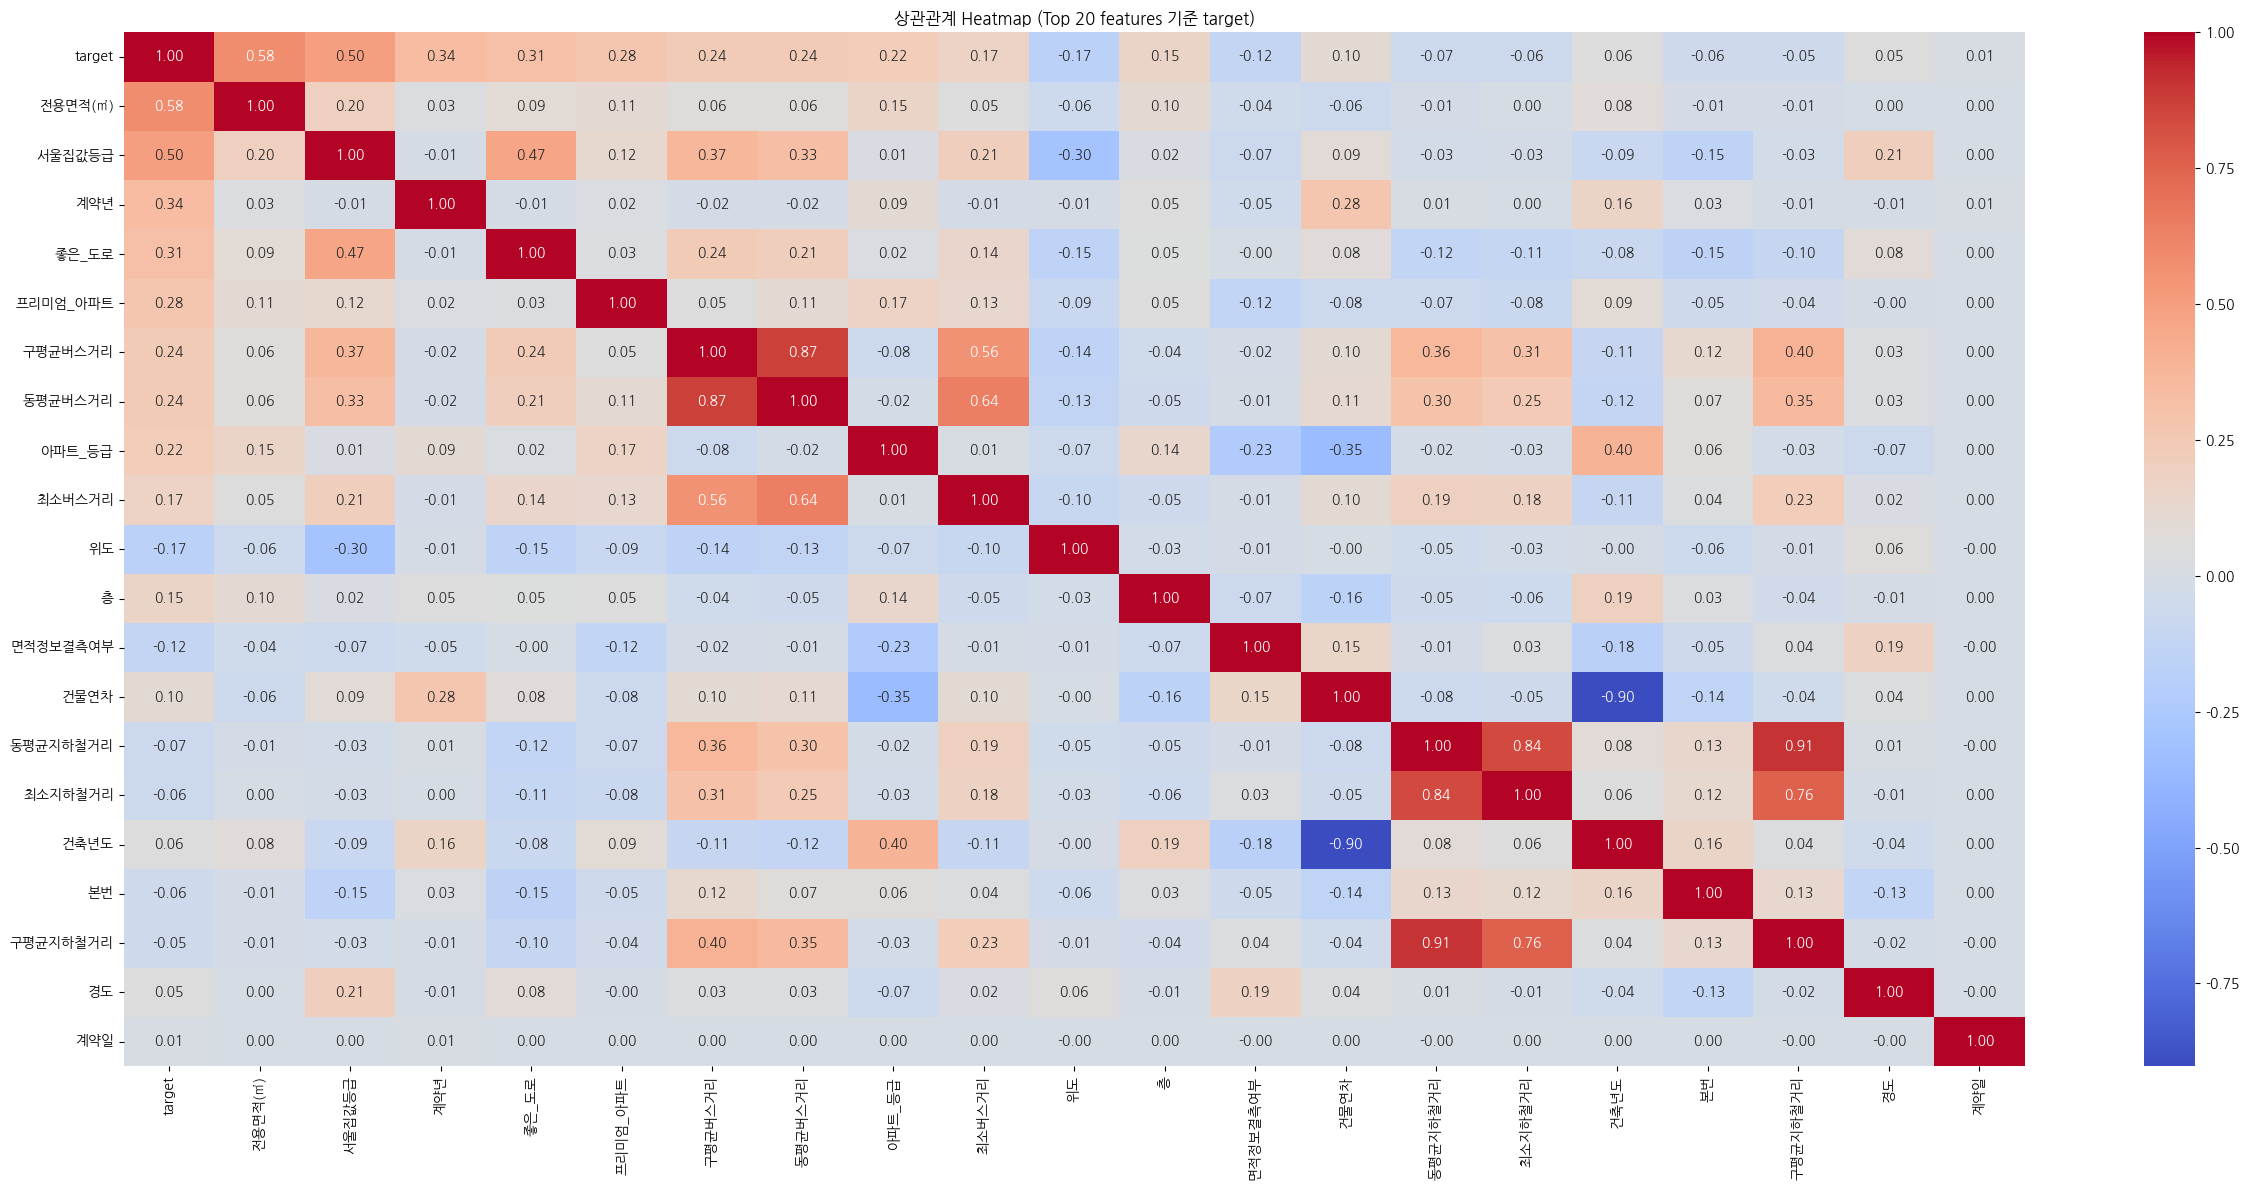

In [65]:
import matplotlib

matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
def plot_corr_heatmap(df, target_col="target", train_flag_col="train_data", topn=20):
    """
    - train 데이터만 사용
    - 수치형 변수의 target과 상관관계 계산
    - 상위 N개 변수 + target으로 heatmap 시각화
    """
    # train만 필터링
    dtrain = df[df[train_flag_col] == 1].copy()
    
    # 수치형 변수만 선택
    num_cols = dtrain.select_dtypes(include=["number"]).columns.tolist()
    if target_col in num_cols:
        pass
    else:
        num_cols.append(target_col)

    # 결측치 중앙값 대체 (상관 안정화)
    dnum = dtrain[num_cols].copy()
    dnum = dnum.fillna(dnum.median())

    # 상관계수 행렬
    corr = dnum.corr()

    # target과 상관 높은 상위 N 변수 선택
    target_corr = corr[target_col].abs().sort_values(ascending=False)
    top_features = target_corr.head(topn+1).index.tolist()  # target 포함

    # Heatmap 그리기
    plt.figure(figsize=(1.2*len(top_features), 12))
    sns.heatmap(corr.loc[top_features, top_features], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"상관관계 Heatmap (Top {topn} features 기준 {target_col})")
    plt.tight_layout()
    plt.show()

# ======================
# 사용 예시
# ======================
plot_corr_heatmap(train, target_col="target", train_flag_col="is_test", topn=20)

In [66]:
train.isnull().sum().sort_values(ascending=False)

주요면적유형      877611
경도          876232
위도          876232
target        9272
아파트명          2136
번지             227
부번              75
본번              75
도로명              0
최소버스거리           0
최소지하철거리          0
동평균버스거리          0
거리보간여부           0
서울집값등급           0
구평균버스거리          0
동평균지하철거리         0
구평균지하철거리         0
계약년              0
프리미엄_아파트         0
동                0
구                0
건축년도             0
아파트_등급           0
좋은_도로            0
is_test          0
면적정보결측여부         0
계약일              0
전용면적(㎡)          0
층                0
건물연차             0
dtype: int64

In [67]:
train.drop(['계약일','번지','구평균버스거리','구평균지하철거리','건축년도'],axis=1,inplace=True)

In [68]:
continuous_columns1= []
categorical_columns1 = []
for column in train.columns:
    if pd.api.types.is_numeric_dtype(train[column]):
        continuous_columns1.append(column)
    else:
        categorical_columns1.append(column)
print("연속형 변수:", continuous_columns1)
print("범주형 변수:", categorical_columns1)

연속형 변수: ['층', '전용면적(㎡)', '부번', '본번', '면적정보결측여부', 'is_test', 'target', '좋은_도로', '아파트_등급', '프리미엄_아파트', '서울집값등급', '계약년', '경도', '위도', '최소버스거리', '최소지하철거리', '거리보간여부', '동평균버스거리', '동평균지하철거리', '건물연차']
범주형 변수: ['도로명', '아파트명', '주요면적유형', '구', '동']


In [69]:
categorical_cols

['main_area_type', '구', '동']

In [70]:
rename = {'전용면적(㎡)':'전용면적'}

train = train.rename(columns=rename)

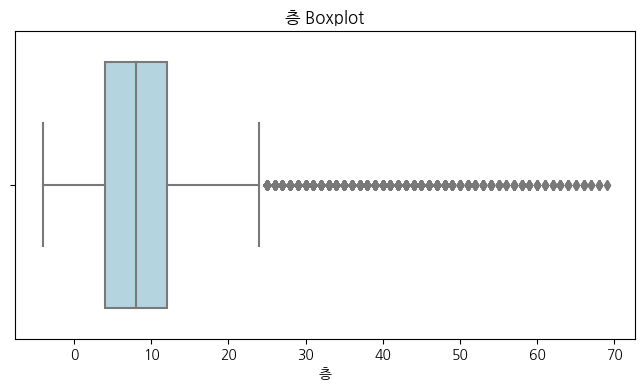

ValueError: Could not interpret input '전용면적(㎡)'

<Figure size 800x400 with 0 Axes>

In [69]:
# 연속형 변수 시각화
for col in continuous_columns1:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=train, x=col, color="lightblue")
    plt.title(f"{col} Boxplot")
    plt.show()

In [71]:
train['층']

0        3
1        4
2        5
3        4
4        2
        ..
9267    13
9268    12
9269    12
9270    18
9271    13
Name: 층, Length: 1128094, dtype: int64

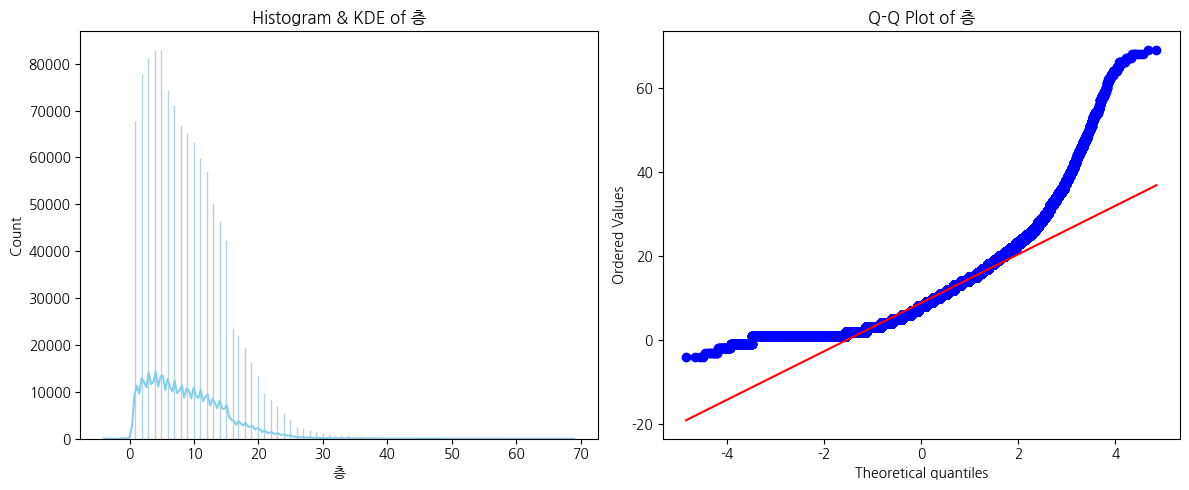

Shapiro-Wilk Test for 층: W=0.9248, p=0.0000
❌ p<=0.05 → 정규분포 아님


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_normality(df, col):
    data = df[col].dropna()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1) 히스토그램 + KDE
    sns.histplot(data, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Histogram & KDE of {col}")

    # 2) Q-Q plot
    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].set_title(f"Q-Q Plot of {col}")

    plt.tight_layout()
    plt.show()

    # 3) Shapiro-Wilk test
    stat, p = stats.shapiro(data)
    print(f"Shapiro-Wilk Test for {col}: W={stat:.4f}, p={p:.4f}")
    if p > 0.05:
        print("✅ p>0.05 → 정규분포 가정을 기각할 수 없음 (정규분포일 가능성 있음)")
    else:
        print("❌ p<=0.05 → 정규분포 아님")

# 사용 예시
check_normality(train, "층")


In [73]:
def add_floor_bin(df, col="층"):
    """
    층 구간화 (binning) 컬럼 추가
    -1 이하: 지하층 → 0
     1~5층 : 저층 → 1
     6~15층: 중층 → 2
     16층 이상: 고층 → 3
    """
    conditions = [
        df[col] <= 0,                     # 지하
        (df[col] >= 1) & (df[col] <= 5),  # 저층
        (df[col] >= 6) & (df[col] <= 15), # 중층
        df[col] >= 16                     # 고층
    ]
    choices = [0, 1, 2, 3]

    df[col + "_bin"] = pd.Series(
        np.select(conditions, choices, default=np.nan),
        index=df.index
    ).astype("Int64")

    return df

# 사용 예시
train = add_floor_bin(train, col="층")
print(train[["층", "층_bin"]].head(20))


     층  층_bin
0    3      1
1    4      1
2    5      1
3    4      1
4    2      1
5    1      1
6    2      1
7    5      1
8    3      1
9    3      1
10   4      1
11   5      1
12   1      1
13   8      2
14   8      2
15   6      2
16  10      2
17  12      2
18  14      2
19  11      2


In [74]:
train

,도로명,층,전용면적,부번,본번,아파트명,면적정보결측여부,주요면적유형,is_test,target,...,계약년,경도,위도,최소버스거리,최소지하철거리,거리보간여부,동평균버스거리,동평균지하철거리,건물연차,층_bin
0,언주로 3,3,79.97,1.0,658.0,개포6차우성,0,2,1,124000.0,...,2017,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.623619,30,1
1,언주로 3,4,79.97,1.0,658.0,개포6차우성,0,2,1,123500.0,...,2017,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.623619,30,1
2,언주로 3,5,54.98,1.0,658.0,개포6차우성,0,2,1,91500.0,...,2017,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.623619,30,1
3,언주로 3,4,79.97,1.0,658.0,개포6차우성,0,2,1,130000.0,...,2018,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.623619,31,1
4,언주로 3,2,79.97,1.0,658.0,개포6차우성,0,2,1,117000.0,...,2018,127.05721,37.476763,0.061783,1.129775,0,0.171702,0.623619,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,13,84.65,0.0,816.0,신내우디안1단지,0,1,0,NaN,...,2023,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.546136,9,2
9268,신내역로1길 85,12,84.62,0.0,816.0,신내우디안1단지,0,1,0,NaN,...,2023,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.546136,9,2
9269,신내역로1길 85,12,101.65,0.0,816.0,신내우디안1단지,0,1,0,NaN,...,2023,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.546136,9,2
9270,신내역로1길 85,18,84.94,0.0,816.0,신내우디안1단지,0,1,0,NaN,...,2023,127.10672,37.618870,0.059517,0.733291,0,0.108639,0.546136,9,3


In [75]:

# 로그화할 컬럼 리스트
log_cols = [
    "전용면적", 
    "건물연차", 
    "최소버스거리", 
    "최소지하철거리", 
    "동평균버스거리", 
    "동평균지하철거리"
]

# log1p 적용
for col in log_cols:
    train[col + "_log"] = np.log1p(train[col])


In [76]:
train

,도로명,층,전용면적,부번,본번,아파트명,면적정보결측여부,주요면적유형,is_test,target,...,동평균버스거리,동평균지하철거리,건물연차,층_bin,전용면적_log,건물연차_log,최소버스거리_log,최소지하철거리_log,동평균버스거리_log,동평균지하철거리_log
0,언주로 3,3,79.97,1.0,658.0,개포6차우성,0,2,1,124000.0,...,0.171702,0.623619,30,1,4.394079,3.433987,0.059950,0.756016,0.158458,0.484658
1,언주로 3,4,79.97,1.0,658.0,개포6차우성,0,2,1,123500.0,...,0.171702,0.623619,30,1,4.394079,3.433987,0.059950,0.756016,0.158458,0.484658
2,언주로 3,5,54.98,1.0,658.0,개포6차우성,0,2,1,91500.0,...,0.171702,0.623619,30,1,4.024994,3.433987,0.059950,0.756016,0.158458,0.484658
3,언주로 3,4,79.97,1.0,658.0,개포6차우성,0,2,1,130000.0,...,0.171702,0.623619,31,1,4.394079,3.465736,0.059950,0.756016,0.158458,0.484658
4,언주로 3,2,79.97,1.0,658.0,개포6차우성,0,2,1,117000.0,...,0.171702,0.623619,31,1,4.394079,3.465736,0.059950,0.756016,0.158458,0.484658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내역로1길 85,13,84.65,0.0,816.0,신내우디안1단지,0,1,0,NaN,...,0.108639,0.546136,9,2,4.450269,2.302585,0.057813,0.550022,0.103133,0.435759
9268,신내역로1길 85,12,84.62,0.0,816.0,신내우디안1단지,0,1,0,NaN,...,0.108639,0.546136,9,2,4.449919,2.302585,0.057813,0.550022,0.103133,0.435759
9269,신내역로1길 85,12,101.65,0.0,816.0,신내우디안1단지,0,1,0,NaN,...,0.108639,0.546136,9,2,4.631325,2.302585,0.057813,0.550022,0.103133,0.435759
9270,신내역로1길 85,18,84.94,0.0,816.0,신내우디안1단지,0,1,0,NaN,...,0.108639,0.546136,9,3,4.453649,2.302585,0.057813,0.550022,0.103133,0.435759


In [77]:
train['도로명'].nunique()

9245

In [78]:
train.isnull().sum().sort_values(ascending=False)

주요면적유형          877611
위도              876232
경도              876232
target            9272
아파트명              2136
본번                  75
부번                  75
최소지하철거리_log          0
최소버스거리_log           0
최소지하철거리              0
건물연차_log             0
전용면적_log             0
층_bin                0
건물연차                 0
동평균지하철거리             0
동평균버스거리              0
거리보간여부               0
동평균버스거리_log          0
도로명                  0
계약년                  0
최소버스거리               0
층                    0
서울집값등급               0
동                    0
구                    0
프리미엄_아파트             0
아파트_등급               0
좋은_도로                0
is_test              0
면적정보결측여부             0
전용면적                 0
동평균지하철거리_log         0
dtype: int64

In [79]:
train.drop(['부번'],axis=1,inplace=True)

In [80]:
train['본번'] = train['본번'].fillna(0)

In [81]:
train['본번'].isnull().sum()

0

In [82]:
# 위도/경도 결측 여부 플래그 생성
train["위도_missing"] = train["위도"].isna().astype(int)
train["경도_missing"] = train["경도"].isna().astype(int)

# 결과 확인
print(train[["위도", "위도_missing", "경도", "경도_missing"]].head(10))


          위도  위도_missing         경도  경도_missing
0  37.476763           0  127.05721           0
1  37.476763           0  127.05721           0
2  37.476763           0  127.05721           0
3  37.476763           0  127.05721           0
4  37.476763           0  127.05721           0
5  37.476763           0  127.05721           0
6  37.476763           0  127.05721           0
7  37.476763           0  127.05721           0
8  37.476763           0  127.05721           0
9  37.476763           0  127.05721           0


In [83]:
train["위도"] = train["위도"].fillna(-1)
train["경도"] = train["경도"].fillna(-1)

In [84]:
train['위도'].isnull().sum()

0

In [85]:
# 1. 결측치 "미상"으로 대체
train["아파트명"] = train["아파트명"].fillna("미상")


# 결과 확인
print(train[["아파트명"]].head(10))



     아파트명
0  개포6차우성
1  개포6차우성
2  개포6차우성
3  개포6차우성
4  개포6차우성
5  개포6차우성
6  개포6차우성
7  개포6차우성
8  개포6차우성
9  개포6차우성


In [86]:
train['아파트명'].isnull().sum()

0

In [87]:
train.isnull().sum()

도로명                  0
층                    0
전용면적                 0
본번                   0
아파트명                 0
면적정보결측여부             0
주요면적유형          877611
is_test              0
target            9272
좋은_도로                0
아파트_등급               0
프리미엄_아파트             0
구                    0
동                    0
서울집값등급               0
계약년                  0
경도                   0
위도                   0
최소버스거리               0
최소지하철거리              0
거리보간여부               0
동평균버스거리              0
동평균지하철거리             0
건물연차                 0
층_bin                0
전용면적_log             0
건물연차_log             0
최소버스거리_log           0
최소지하철거리_log          0
동평균버스거리_log          0
동평균지하철거리_log         0
위도_missing           0
경도_missing           0
dtype: int64

In [88]:
train['주요면적유형']

0       2
1       2
2       2
3       2
4       2
       ..
9267    1
9268    1
9269    1
9270    1
9271    1
Name: 주요면적유형, Length: 1128094, dtype: category
Categories (4, int64): [1, 2, 3, 4]

In [89]:
col = "주요면적유형"

# 1) 카테고리/문자든 뭐든 숫자로 강제 변환 (1,2,3,4는 그대로; 결측/이상치는 NaN)
train[col] = pd.to_numeric(train[col], errors="coerce")

# 2) 결측을 -1로 채우고 정수로 캐스팅
train[col] = train[col].fillna(-1).astype("int16")  # int8도 가능

# 확인
print(train[col].value_counts(dropna=False).sort_index())
print(train[col].dtype)



-1    877611
 1    102282
 2    123081
 3     25120
Name: 주요면적유형, dtype: int64
int16


In [90]:
train.isnull().sum().sort_values(ascending=False)

target          9272
전용면적_log           0
최소지하철거리            0
거리보간여부             0
동평균버스거리            0
동평균지하철거리           0
건물연차               0
층_bin              0
도로명                0
위도                 0
건물연차_log           0
최소버스거리_log         0
최소지하철거리_log        0
동평균버스거리_log        0
동평균지하철거리_log       0
위도_missing         0
최소버스거리             0
경도                 0
층                  0
계약년                0
서울집값등급             0
동                  0
구                  0
프리미엄_아파트           0
아파트_등급             0
좋은_도로              0
is_test            0
주요면적유형             0
면적정보결측여부           0
아파트명               0
본번                 0
전용면적               0
경도_missing         0
dtype: int64

In [91]:
train.columns

Index(['도로명', '층', '전용면적', '본번', '아파트명', '면적정보결측여부', '주요면적유형', 'is_test',
       'target', '좋은_도로', '아파트_등급', '프리미엄_아파트', '구', '동', '서울집값등급', '계약년',
       '경도', '위도', '최소버스거리', '최소지하철거리', '거리보간여부', '동평균버스거리', '동평균지하철거리',
       '건물연차', '층_bin', '전용면적_log', '건물연차_log', '최소버스거리_log', '최소지하철거리_log',
       '동평균버스거리_log', '동평균지하철거리_log', '위도_missing', '경도_missing'],
      dtype='object')

In [92]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩할 컬럼 후보
cat_cols = ["도로명", "아파트명", "구", "동"]

# 실제 존재하고 object 타입인 컬럼만 선택
cat_cols = [col for col in cat_cols if col in train.columns and train[col].dtype == "object"]

# 각 컬럼별 라벨 인코더 적용
for col in cat_cols:
    le = LabelEncoder()
    train[col] = train[col].fillna("missing")  # 결측은 "missing"으로 처리
    train[col] = le.fit_transform(train[col])
    print(f"{col}: {len(le.classes_)} classes")


도로명: 9245 classes
아파트명: 6550 classes
구: 25 classes
동: 337 classes


In [93]:
df = train.copy()

In [94]:
df

,도로명,층,전용면적,본번,아파트명,면적정보결측여부,주요면적유형,is_test,target,좋은_도로,...,건물연차,층_bin,전용면적_log,건물연차_log,최소버스거리_log,최소지하철거리_log,동평균버스거리_log,동평균지하철거리_log,위도_missing,경도_missing
0,6185,3,79.97,658.0,327,0,2,1,124000.0,1,...,30,1,4.394079,3.433987,0.059950,0.756016,0.158458,0.484658,0,0
1,6185,4,79.97,658.0,327,0,2,1,123500.0,1,...,30,1,4.394079,3.433987,0.059950,0.756016,0.158458,0.484658,0,0
2,6185,5,54.98,658.0,327,0,2,1,91500.0,1,...,30,1,4.024994,3.433987,0.059950,0.756016,0.158458,0.484658,0,0
3,6185,4,79.97,658.0,327,0,2,1,130000.0,1,...,31,1,4.394079,3.465736,0.059950,0.756016,0.158458,0.484658,0,0
4,6185,2,79.97,658.0,327,0,2,1,117000.0,1,...,31,1,4.394079,3.465736,0.059950,0.756016,0.158458,0.484658,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,5564,13,84.65,816.0,3674,0,1,0,NaN,0,...,9,2,4.450269,2.302585,0.057813,0.550022,0.103133,0.435759,0,0
9268,5564,12,84.62,816.0,3674,0,1,0,NaN,0,...,9,2,4.449919,2.302585,0.057813,0.550022,0.103133,0.435759,0,0
9269,5564,12,101.65,816.0,3674,0,1,0,NaN,0,...,9,2,4.631325,2.302585,0.057813,0.550022,0.103133,0.435759,0,0
9270,5564,18,84.94,816.0,3674,0,1,0,NaN,0,...,9,3,4.453649,2.302585,0.057813,0.550022,0.103133,0.435759,0,0


In [99]:
# 1. 학습용 데이터 (is_test = 1)
train_set = train[train["is_test"] == 1]
X_train = train_set.drop(columns=["target", "is_test"])
y_train = train_set["target"]

# 2. 테스트 데이터 (is_test = 0)
test_set = train[train["is_test"] == 0]
X_test = test_set.drop(columns=["target", "is_test"])
y_test = test_set["target"]

# 3. 확인
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)


X_train: (1118822, 31) y_train: (1118822,)
X_test : (9272, 31) y_test : (9272,)


In [100]:


def split_train_val_by_year(X, y, year_col="계약년", val_year=2020):
    """
    X, y를 계약년 기준으로 train/val 분리
    - X: 특징 데이터프레임
    - y: 타깃 시리즈/데이터프레임
    - year_col: 연도 컬럼 이름
    - val_year: 기준 연도 (이상은 val로 감)
    """
    # 연도 추출
    years = pd.to_numeric(X[year_col], errors="coerce")
    
    # 마스크 생성
    val_mask = years >= val_year

    # 분리
    X_train_final = X[~val_mask].copy()
    y_train_final = y[~val_mask].copy()
    X_val = X[val_mask].copy()
    y_val = y[val_mask].copy()

    return X_train_final, X_val, y_train_final, y_val


# 사용 예시
X_train_final, X_val, y_train_final, y_val = split_train_val_by_year(
    X_train, y_train, year_col="계약년", val_year=2020
)

print("훈련 세트:", X_train_final.shape, y_train_final.shape)
print("검증 세트:", X_val.shape, y_val.shape)




훈련 세트: (962232, 31) (962232,)
검증 세트: (156590, 31) (156590,)


In [101]:
X_train_final.shape , X_val.shape

((962232, 31), (156590, 31))

X_train: (716045, 31) y_train: (716045,)
X_valid: (179012, 31) y_valid: (179012,)


,도로명,층,전용면적,본번,아파트명,면적정보결측여부,주요면적유형,좋은_도로,아파트_등급,프리미엄_아파트,...,건물연차,층_bin,전용면적_log,건물연차_log,최소버스거리_log,최소지하철거리_log,동평균버스거리_log,동평균지하철거리_log,위도_missing,경도_missing
0,6185,5,79.9700,658.0,327,0,2,1,1,0,...,36,1,4.394079,3.610918,0.059950,0.756016,0.158458,0.484658,0,0
1,469,10,108.2017,651.0,328,0,3,1,3,0,...,2,2,4.693197,1.098612,0.118647,0.267485,0.158458,0.484658,0,0
2,467,15,161.0000,652.0,332,0,3,1,1,0,...,39,2,5.087596,3.688879,0.093747,0.346243,0.158458,0.484658,0,0
3,467,14,133.4600,652.0,332,0,3,1,1,0,...,39,2,4.901267,3.688879,0.093747,0.346243,0.158458,0.484658,0,0
4,467,6,104.4300,652.0,332,0,3,1,1,0,...,39,2,4.658047,3.688879,0.093747,0.346243,0.158458,0.484658,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,5564,13,84.6500,816.0,3674,0,1,0,1,0,...,9,2,4.450269,2.302585,0.057813,0.550022,0.103133,0.435759,0,0
9268,5564,12,84.6200,816.0,3674,0,1,0,1,0,...,9,2,4.449919,2.302585,0.057813,0.550022,0.103133,0.435759,0,0
9269,5564,12,101.6500,816.0,3674,0,1,0,1,0,...,9,2,4.631325,2.302585,0.057813,0.550022,0.103133,0.435759,0,0
9270,5564,18,84.9400,816.0,3674,0,1,0,1,0,...,9,3,4.453649,2.302585,0.057813,0.550022,0.103133,0.435759,0,0


In [102]:
cat_features = [
    "도로명", "아파트명", "구", "동",
    "아파트_등급", "프리미엄_아파트", "서울집값등급",
    "층_bin", "좋은_도로", "면적정보결측여부",
    "거리보간여부", "위도_missing", "경도_missing"
]
cat_features = [col for col in cat_features if col in X_train.columns]

In [ ]:
# --- 0) 필요 라이브러리 ---
import lightgbm as lgb
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd

# (선택) 네가 앞서 만든 평가 함수가 없다면 주석 해제해서 사용
from sklearn import metrics
def evaluate_regression(model, X_train, y_train, X_val, y_val):
    pred_tr = model.predict(X_train)
    pred_va = model.predict(X_val)
    import sklearn.metrics as M
    mae_tr  = M.mean_absolute_error(y_train, pred_tr)
    rmse_tr = np.sqrt(M.mean_squared_error(y_train, pred_tr))
    r2_tr   = M.r2_score(y_train, pred_tr)     
    err_tr  = rmse_tr / (np.mean(y_train) + 1e-12)
    mae_va  = M.mean_absolute_error(y_val, pred_va)
    rmse_va = np.sqrt(M.mean_squared_error(y_val, pred_va))
    r2_va   = M.r2_score(y_val, pred_va)
    err_va  = rmse_va / (np.mean(y_val) + 1e-12)
    print(f"Train R2={r2_tr:.4f} RMSE={rmse_tr:,.4f} MAE={mae_tr:,.4f} Err={err_tr:.2%}")
    print(f"Valid R2={r2_va:.4f} RMSE={rmse_va:,.4f} MAE={mae_va:,.4f} Err={err_va:.2%}")
    return {"train": {"R2": r2_tr, "RMSE": rmse_tr, "MAE": mae_tr, "Err": err_tr},
           "valid": {"R2": r2_va, "RMSE": rmse_va, "MAE": mae_va, "Err": err_va}}

# --- 1) 범주형 컬럼 인덱스 지정 (라벨 인코딩된 정수여야 함) ---
# 예: categorical_columns_v2 = ['k-난방방식','구','동']
cat_idx = [X_train_final.columns.get_loc(c) for c in cat_features if c in X_train_final.columns]

# --- 2) 콜백(조기 종료/로그) ---
callbacks = [
    lgb.early_stopping(stopping_rounds=200, verbose=False),
    lgb.log_evaluation(period=100)
]

best_params_search = {
    'learning_rate': 0.04656555870183847,
    'num_leaves': 116,
    'max_depth': 14,
    'min_data_in_leaf': 42,
    'feature_fraction': 0.7437919226019789,
    'bagging_fraction': 0.9455718071550593,
    'bagging_freq': 0,
    'lambda_l1': 0.0006984776255885442,
    'lambda_l2': 7.465964782876006e-06,
    'min_gain_to_split': 3.514707183072839,
    'max_bin': 342
    
}
# --- 3) 모델 정의 ---
final_params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "n_estimators": 20000,     # 최종 단계: 충분히 크게 주고
    "n_jobs": -1,
    **best_params_search,      # 네 Best Params 그대로 사용
}

# --- 4) 학습 ---
final_model = LGBMRegressor(**final_params)
final_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],            # 조기종료 기준만으로 사용
    eval_metric="rmse",
    categorical_feature=cat_features if len(cat_features) else None,
    callbacks=[lgb.early_stopping(stopping_rounds=400, verbose=False)],
)

# --- 5) 평가 ---
results = evaluate_regression(final_model, X_train_final, y_train_final, X_val, y_val)


Train R2=0.9876 RMSE=4,337.7997 MAE=2,471.7102 Err=8.30%
Valid R2=0.7981 RMSE=30,638.2809 MAE=20,648.8291 Err=32.81%


In [ ]:
# =========================
# 범주형 컬럼 지정
# =========================
cat_features = [
    "도로명", "아파트명", "구", "동",
    "아파트_등급", "프리미엄_아파트", "서울집값등급",
    "층_bin", "좋은_도로", "면적정보결측여부",
    "거리보간여부", "위도_missing", "경도_missing"
]
cat_features = [col for col in cat_features if col in X_train_final.columns]

# =========================
# 1) Optuna 목적함수
# =========================
def objective(trial: optuna.Trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "n_estimators": 4000,               # early stopping으로 자동 제한
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 255, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 2000, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 5.0),
        "max_bin": trial.suggest_int("max_bin", 127, 511),
        # GPU가 안정적이면 아래 주석 해제
        # "device_type": "gpu",
    }

    model = LGBMRegressor(**params)
    model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_features,
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],  # ← None 제거
    )

    best_iter = getattr(model, "best_iteration_", None)
    if best_iter is not None:
        y_pred = model.predict(X_val, num_iteration=best_iter)
    else:
        y_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

# =========================
# 2) 최적화 실행
# =========================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best Params:", study.best_params)

# =========================
# 3) 최적 파라미터로 재학습 (train+valid 합쳐서)
# =========================
best_params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "n_estimators": 10000,
    **study.best_params,
}

final_model = LGBMRegressor(**best_params)

X_full = pd.concat([X_train_final, X_val], axis=0)
y_full = pd.concat([y_train_final, y_val], axis=0)

final_model.fit(
    X_full, y_full,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_features,
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
)


print("Final best_iteration_:", getattr(final_model, "best_iteration_", None))


[I 2025-09-07 15:46:42,492] A new study created in memory with name: no-name-293c192f-ec22-433e-9eeb-ed9326d2a64f
Best trial: 0. Best value: 7343.47:   3%|▎         | 1/30 [01:42<49:39, 102.73s/it]

[I 2025-09-07 15:48:25,219] Trial 0 finished with value: 7343.474047899356 and parameters: {'learning_rate': 0.08165020284965485, 'num_leaves': 193, 'max_depth': 13, 'min_data_in_leaf': 410, 'feature_fraction': 0.8049658369534747, 'bagging_fraction': 0.6452772431540598, 'bagging_freq': 10, 'lambda_l1': 1.970306805649333e-07, 'lambda_l2': 0.00018433823426776473, 'min_gain_to_split': 1.7840135618632758, 'max_bin': 276}. Best is trial 0 with value: 7343.474047899356.


Best trial: 1. Best value: 7020.08:   7%|▋         | 2/30 [02:57<40:18, 86.36s/it] 

[I 2025-09-07 15:49:40,118] Trial 1 finished with value: 7020.078993093916 and parameters: {'learning_rate': 0.13197235427792475, 'num_leaves': 221, 'max_depth': 7, 'min_data_in_leaf': 321, 'feature_fraction': 0.8480259837009793, 'bagging_fraction': 0.9605759197198698, 'bagging_freq': 9, 'lambda_l1': 7.866789360432105e-06, 'lambda_l2': 0.0009974892225686986, 'min_gain_to_split': 1.054931923810346, 'max_bin': 409}. Best is trial 1 with value: 7020.078993093916.


Best trial: 2. Best value: 6866.9:  10%|█         | 3/30 [05:16<49:41, 110.41s/it]

[I 2025-09-07 15:51:59,148] Trial 2 finished with value: 6866.898508142603 and parameters: {'learning_rate': 0.08986049365785538, 'num_leaves': 206, 'max_depth': 16, 'min_data_in_leaf': 644, 'feature_fraction': 0.7326691958148537, 'bagging_fraction': 0.9239291249926772, 'bagging_freq': 0, 'lambda_l1': 5.442790949200066e-07, 'lambda_l2': 0.4277356280777571, 'min_gain_to_split': 0.984671545621294, 'max_bin': 454}. Best is trial 2 with value: 6866.898508142603.


Best trial: 2. Best value: 6866.9:  13%|█▎        | 4/30 [06:24<40:29, 93.43s/it] 

[I 2025-09-07 15:53:06,551] Trial 3 finished with value: 7644.61786247059 and parameters: {'learning_rate': 0.07866845708593109, 'num_leaves': 129, 'max_depth': 8, 'min_data_in_leaf': 365, 'feature_fraction': 0.7217655672222527, 'bagging_fraction': 0.6354408284592203, 'bagging_freq': 5, 'lambda_l1': 0.0028492263490165837, 'lambda_l2': 0.9324308966965618, 'min_gain_to_split': 0.5681297484308179, 'max_bin': 195}. Best is trial 2 with value: 6866.898508142603.


Best trial: 4. Best value: 6808.19:  17%|█▋        | 5/30 [08:32<44:15, 106.21s/it]

[I 2025-09-07 15:55:15,432] Trial 4 finished with value: 6808.188603876018 and parameters: {'learning_rate': 0.07846910863739849, 'num_leaves': 45, 'max_depth': 15, 'min_data_in_leaf': 255, 'feature_fraction': 0.6789035240512784, 'bagging_fraction': 0.9017399117700611, 'bagging_freq': 5, 'lambda_l1': 0.5850066165436497, 'lambda_l2': 1.7241604446553122e-08, 'min_gain_to_split': 2.196925433857359, 'max_bin': 366}. Best is trial 4 with value: 6808.188603876018.


Best trial: 4. Best value: 6808.19:  20%|██        | 6/30 [09:57<39:36, 99.01s/it] 

[I 2025-09-07 15:56:40,452] Trial 5 finished with value: 7327.349996059016 and parameters: {'learning_rate': 0.03697378332775274, 'num_leaves': 74, 'max_depth': 9, 'min_data_in_leaf': 182, 'feature_fraction': 0.7916364168905421, 'bagging_fraction': 0.7590411560586833, 'bagging_freq': 9, 'lambda_l1': 3.268668385888064e-08, 'lambda_l2': 0.13301024470800552, 'min_gain_to_split': 1.3325594574115547, 'max_bin': 210}. Best is trial 4 with value: 6808.188603876018.


Best trial: 4. Best value: 6808.19:  23%|██▎       | 7/30 [12:00<40:51, 106.57s/it]

[I 2025-09-07 15:58:42,583] Trial 6 finished with value: 7267.579782360215 and parameters: {'learning_rate': 0.047872496531236305, 'num_leaves': 95, 'max_depth': 15, 'min_data_in_leaf': 580, 'feature_fraction': 0.6207359481544935, 'bagging_fraction': 0.7870616309214532, 'bagging_freq': 5, 'lambda_l1': 2.4290839366906896e-06, 'lambda_l2': 3.838298029836953e-08, 'min_gain_to_split': 3.1372659230665736, 'max_bin': 352}. Best is trial 4 with value: 6808.188603876018.


Best trial: 4. Best value: 6808.19:  27%|██▋       | 8/30 [13:27<36:48, 100.37s/it]

[I 2025-09-07 16:00:09,673] Trial 7 finished with value: 7060.906389480831 and parameters: {'learning_rate': 0.09427261836048753, 'num_leaves': 126, 'max_depth': 8, 'min_data_in_leaf': 32, 'feature_fraction': 0.9706312218276949, 'bagging_fraction': 0.7397672383598094, 'bagging_freq': 4, 'lambda_l1': 0.042308588862021566, 'lambda_l2': 0.04121336463027202, 'min_gain_to_split': 1.509531753596215, 'max_bin': 400}. Best is trial 4 with value: 6808.188603876018.


Best trial: 4. Best value: 6808.19:  30%|███       | 9/30 [14:56<33:57, 97.01s/it] 

[I 2025-09-07 16:01:39,299] Trial 8 finished with value: 7608.110416442553 and parameters: {'learning_rate': 0.03650094009542949, 'num_leaves': 201, 'max_depth': 9, 'min_data_in_leaf': 358, 'feature_fraction': 0.8187243282236887, 'bagging_fraction': 0.805516936958869, 'bagging_freq': 6, 'lambda_l1': 0.00022884694607780518, 'lambda_l2': 3.8850251188012255e-08, 'min_gain_to_split': 2.171882635683483, 'max_bin': 254}. Best is trial 4 with value: 6808.188603876018.


Best trial: 4. Best value: 6808.19:  33%|███▎      | 10/30 [16:01<29:01, 87.07s/it]

[I 2025-09-07 16:02:44,103] Trial 9 finished with value: 7050.3145937856725 and parameters: {'learning_rate': 0.08430986400129313, 'num_leaves': 202, 'max_depth': 8, 'min_data_in_leaf': 34, 'feature_fraction': 0.8201613824174562, 'bagging_fraction': 0.845352421159194, 'bagging_freq': 6, 'lambda_l1': 0.9615755626012074, 'lambda_l2': 0.00015576397075764165, 'min_gain_to_split': 4.396291083901055, 'max_bin': 309}. Best is trial 4 with value: 6808.188603876018.


Best trial: 4. Best value: 6808.19:  37%|███▋      | 11/30 [16:45<23:20, 73.72s/it]

[I 2025-09-07 16:03:27,548] Trial 10 finished with value: 8577.380186334363 and parameters: {'learning_rate': 0.19928060015844343, 'num_leaves': 35, 'max_depth': 3, 'min_data_in_leaf': 1777, 'feature_fraction': 0.6097037678725902, 'bagging_fraction': 0.8874912714001462, 'bagging_freq': 2, 'lambda_l1': 6.659406838179628, 'lambda_l2': 1.9903761408853907e-06, 'min_gain_to_split': 3.109031180193717, 'max_bin': 509}. Best is trial 4 with value: 6808.188603876018.


Best trial: 11. Best value: 6702.43:  40%|████      | 12/30 [18:07<22:55, 76.44s/it]

[I 2025-09-07 16:04:50,231] Trial 11 finished with value: 6702.431644679935 and parameters: {'learning_rate': 0.055871576928658795, 'num_leaves': 40, 'max_depth': 16, 'min_data_in_leaf': 145, 'feature_fraction': 0.7036340251379529, 'bagging_fraction': 0.9888756854977256, 'bagging_freq': 0, 'lambda_l1': 0.0001740669750358315, 'lambda_l2': 4.087862516161734, 'min_gain_to_split': 0.16407357581923332, 'max_bin': 507}. Best is trial 11 with value: 6702.431644679935.


Best trial: 12. Best value: 6662.77:  43%|████▎     | 13/30 [19:23<21:36, 76.26s/it]

[I 2025-09-07 16:06:06,082] Trial 12 finished with value: 6662.774466718587 and parameters: {'learning_rate': 0.05473731927036429, 'num_leaves': 39, 'max_depth': 13, 'min_data_in_leaf': 103, 'feature_fraction': 0.6869783268667397, 'bagging_fraction': 0.9787604589887127, 'bagging_freq': 0, 'lambda_l1': 0.00014661771424564332, 'lambda_l2': 9.090352929903881, 'min_gain_to_split': 4.663262092588775, 'max_bin': 499}. Best is trial 12 with value: 6662.774466718587.


Best trial: 13. Best value: 6649.81:  47%|████▋     | 14/30 [20:48<21:02, 78.89s/it]

[I 2025-09-07 16:07:31,051] Trial 13 finished with value: 6649.811742759762 and parameters: {'learning_rate': 0.0566937410561699, 'num_leaves': 51, 'max_depth': 12, 'min_data_in_leaf': 98, 'feature_fraction': 0.6755135904225394, 'bagging_fraction': 0.9972268981467552, 'bagging_freq': 0, 'lambda_l1': 0.0002131387146629152, 'lambda_l2': 6.698228994556285, 'min_gain_to_split': 4.677837272862882, 'max_bin': 496}. Best is trial 13 with value: 6649.811742759762.


Best trial: 13. Best value: 6649.81:  50%|█████     | 15/30 [22:45<22:37, 90.51s/it]

[I 2025-09-07 16:09:28,482] Trial 14 finished with value: 6999.885416525687 and parameters: {'learning_rate': 0.054610164166798196, 'num_leaves': 54, 'max_depth': 12, 'min_data_in_leaf': 88, 'feature_fraction': 0.666434116811727, 'bagging_fraction': 0.9896870069994788, 'bagging_freq': 2, 'lambda_l1': 2.119583406078549e-05, 'lambda_l2': 6.792853065438534, 'min_gain_to_split': 4.985121477854674, 'max_bin': 139}. Best is trial 13 with value: 6649.811742759762.


Best trial: 13. Best value: 6649.81:  53%|█████▎    | 16/30 [25:04<24:30, 105.07s/it]

[I 2025-09-07 16:11:47,356] Trial 15 finished with value: 6783.197802040708 and parameters: {'learning_rate': 0.046393141197212856, 'num_leaves': 57, 'max_depth': 12, 'min_data_in_leaf': 81, 'feature_fraction': 0.7543811851628641, 'bagging_fraction': 0.9307660244361149, 'bagging_freq': 2, 'lambda_l1': 0.0037643773329103943, 'lambda_l2': 0.006815307060023282, 'min_gain_to_split': 4.006693595159566, 'max_bin': 462}. Best is trial 13 with value: 6649.811742759762.


Best trial: 13. Best value: 6649.81:  57%|█████▋    | 17/30 [26:33<21:40, 100.05s/it]

[I 2025-09-07 16:13:15,741] Trial 16 finished with value: 6894.414913961751 and parameters: {'learning_rate': 0.06017796524610788, 'num_leaves': 32, 'max_depth': 11, 'min_data_in_leaf': 56, 'feature_fraction': 0.6508208098497743, 'bagging_fraction': 0.8637139449896563, 'bagging_freq': 1, 'lambda_l1': 0.004351746445416996, 'lambda_l2': 0.008865339500875225, 'min_gain_to_split': 3.851824898596293, 'max_bin': 456}. Best is trial 13 with value: 6649.811742759762.


Best trial: 13. Best value: 6649.81:  60%|██████    | 18/30 [28:45<21:55, 109.59s/it]

[I 2025-09-07 16:15:27,537] Trial 17 finished with value: 7056.05756087101 and parameters: {'learning_rate': 0.0305436746580177, 'num_leaves': 62, 'max_depth': 14, 'min_data_in_leaf': 137, 'feature_fraction': 0.9052745872209627, 'bagging_fraction': 0.6907713268938356, 'bagging_freq': 3, 'lambda_l1': 4.066165236983356e-05, 'lambda_l2': 2.580089462655171e-06, 'min_gain_to_split': 4.800944534834997, 'max_bin': 417}. Best is trial 13 with value: 6649.811742759762.


Best trial: 18. Best value: 6647.6:  63%|██████▎   | 19/30 [29:41<17:09, 93.59s/it]  

[I 2025-09-07 16:16:23,854] Trial 18 finished with value: 6647.600102733973 and parameters: {'learning_rate': 0.1242337625091579, 'num_leaves': 49, 'max_depth': 11, 'min_data_in_leaf': 23, 'feature_fraction': 0.7715759963760505, 'bagging_fraction': 0.9990687193072588, 'bagging_freq': 0, 'lambda_l1': 0.02990985990715151, 'lambda_l2': 3.942359372599536, 'min_gain_to_split': 3.291868758066074, 'max_bin': 483}. Best is trial 18 with value: 6647.600102733973.


Best trial: 18. Best value: 6647.6:  67%|██████▋   | 20/30 [30:39<13:50, 83.07s/it]

[I 2025-09-07 16:17:22,419] Trial 19 finished with value: 7061.629411111266 and parameters: {'learning_rate': 0.1185035541147868, 'num_leaves': 84, 'max_depth': 5, 'min_data_in_leaf': 22, 'feature_fraction': 0.8745813355985926, 'bagging_fraction': 0.948137244870613, 'bagging_freq': 1, 'lambda_l1': 0.04557492470562036, 'lambda_l2': 0.5528362797813364, 'min_gain_to_split': 3.139633797784664, 'max_bin': 367}. Best is trial 18 with value: 6647.600102733973.


Best trial: 18. Best value: 6647.6:  70%|███████   | 21/30 [32:04<12:31, 83.47s/it]

[I 2025-09-07 16:18:46,806] Trial 20 finished with value: 6851.144318331024 and parameters: {'learning_rate': 0.16436855471884962, 'num_leaves': 46, 'max_depth': 11, 'min_data_in_leaf': 53, 'feature_fraction': 0.7838950305878646, 'bagging_fraction': 0.8226995151528492, 'bagging_freq': 7, 'lambda_l1': 0.023957007861658042, 'lambda_l2': 0.02872453329485529, 'min_gain_to_split': 3.631179364198002, 'max_bin': 441}. Best is trial 18 with value: 6647.600102733973.


Best trial: 18. Best value: 6647.6:  73%|███████▎  | 22/30 [33:23<10:58, 82.29s/it]

[I 2025-09-07 16:20:06,360] Trial 21 finished with value: 6658.653985870158 and parameters: {'learning_rate': 0.06490236320529977, 'num_leaves': 45, 'max_depth': 11, 'min_data_in_leaf': 93, 'feature_fraction': 0.7540978622316116, 'bagging_fraction': 0.9992453733256081, 'bagging_freq': 0, 'lambda_l1': 0.0007166459145354304, 'lambda_l2': 9.545511793374784, 'min_gain_to_split': 4.384358327623777, 'max_bin': 484}. Best is trial 18 with value: 6647.600102733973.


Best trial: 22. Best value: 6607.64:  77%|███████▋  | 23/30 [34:43<09:30, 81.56s/it]

[I 2025-09-07 16:21:26,203] Trial 22 finished with value: 6607.642701422445 and parameters: {'learning_rate': 0.0672918863524078, 'num_leaves': 64, 'max_depth': 11, 'min_data_in_leaf': 21, 'feature_fraction': 0.7563609604675048, 'bagging_fraction': 0.9992601260049846, 'bagging_freq': 1, 'lambda_l1': 0.0012273139050018873, 'lambda_l2': 1.2280247897438898, 'min_gain_to_split': 4.181117145132361, 'max_bin': 472}. Best is trial 22 with value: 6607.642701422445.


Best trial: 22. Best value: 6607.64:  80%|████████  | 24/30 [36:20<08:36, 86.14s/it]

[I 2025-09-07 16:23:03,046] Trial 23 finished with value: 6764.132011112981 and parameters: {'learning_rate': 0.10750762238324461, 'num_leaves': 70, 'max_depth': 10, 'min_data_in_leaf': 22, 'feature_fraction': 0.765335524211645, 'bagging_fraction': 0.9526241812752573, 'bagging_freq': 1, 'lambda_l1': 0.24902217121860698, 'lambda_l2': 1.272646730868574, 'min_gain_to_split': 3.4901504551998745, 'max_bin': 477}. Best is trial 22 with value: 6607.642701422445.


Best trial: 22. Best value: 6607.64:  83%|████████▎ | 25/30 [38:10<07:45, 93.17s/it]

[I 2025-09-07 16:24:52,614] Trial 24 finished with value: 6702.315716159309 and parameters: {'learning_rate': 0.06617632622683645, 'num_leaves': 97, 'max_depth': 10, 'min_data_in_leaf': 45, 'feature_fraction': 0.6430393242769792, 'bagging_fraction': 0.907517017013181, 'bagging_freq': 3, 'lambda_l1': 0.0009754369456250428, 'lambda_l2': 0.1248257496491009, 'min_gain_to_split': 2.6685939427387115, 'max_bin': 426}. Best is trial 22 with value: 6607.642701422445.


Best trial: 22. Best value: 6607.64:  87%|████████▋ | 26/30 [39:27<05:53, 88.42s/it]

[I 2025-09-07 16:26:09,960] Trial 25 finished with value: 6789.310215682249 and parameters: {'learning_rate': 0.13979580896214705, 'num_leaves': 53, 'max_depth': 13, 'min_data_in_leaf': 31, 'feature_fraction': 0.7190145106779442, 'bagging_fraction': 0.8744841899333728, 'bagging_freq': 1, 'lambda_l1': 0.008304332279146922, 'lambda_l2': 2.0745683544126186, 'min_gain_to_split': 4.132027237569728, 'max_bin': 468}. Best is trial 22 with value: 6607.642701422445.


Best trial: 22. Best value: 6607.64:  90%|█████████ | 27/30 [40:49<04:19, 86.47s/it]

[I 2025-09-07 16:27:31,859] Trial 26 finished with value: 6960.097273169298 and parameters: {'learning_rate': 0.10234427598943702, 'num_leaves': 69, 'max_depth': 6, 'min_data_in_leaf': 23, 'feature_fraction': 0.9216406749992945, 'bagging_fraction': 0.9671017055387827, 'bagging_freq': 2, 'lambda_l1': 5.7127290883890777e-05, 'lambda_l2': 0.0018820297404924008, 'min_gain_to_split': 4.439526994104654, 'max_bin': 386}. Best is trial 22 with value: 6607.642701422445.


Best trial: 22. Best value: 6607.64:  93%|█████████▎| 28/30 [42:50<03:13, 96.96s/it]

[I 2025-09-07 16:29:33,288] Trial 27 finished with value: 6768.815293737674 and parameters: {'learning_rate': 0.07126354225264621, 'num_leaves': 51, 'max_depth': 12, 'min_data_in_leaf': 66, 'feature_fraction': 0.8477020599289232, 'bagging_fraction': 0.9239235271616071, 'bagging_freq': 3, 'lambda_l1': 0.06559897241559141, 'lambda_l2': 0.12864119412584069, 'min_gain_to_split': 2.730427282657667, 'max_bin': 312}. Best is trial 22 with value: 6607.642701422445.


Best trial: 28. Best value: 6536.34:  97%|█████████▋| 29/30 [44:46<01:42, 102.54s/it]

[I 2025-09-07 16:31:28,867] Trial 28 finished with value: 6536.342045570257 and parameters: {'learning_rate': 0.04656555870183847, 'num_leaves': 116, 'max_depth': 14, 'min_data_in_leaf': 42, 'feature_fraction': 0.7437919226019789, 'bagging_fraction': 0.9455718071550593, 'bagging_freq': 0, 'lambda_l1': 0.0006984776255885442, 'lambda_l2': 7.465964782876006e-06, 'min_gain_to_split': 3.514707183072839, 'max_bin': 342}. Best is trial 28 with value: 6536.342045570257.


Best trial: 28. Best value: 6536.34: 100%|██████████| 30/30 [46:53<00:00, 93.77s/it] 


[I 2025-09-07 16:33:35,645] Trial 29 finished with value: 6902.289714682173 and parameters: {'learning_rate': 0.047624957194353175, 'num_leaves': 120, 'max_depth': 14, 'min_data_in_leaf': 39, 'feature_fraction': 0.7903863063214573, 'bagging_fraction': 0.6766394249700287, 'bagging_freq': 1, 'lambda_l1': 0.0010361301965644506, 'lambda_l2': 1.1691474434338457e-05, 'min_gain_to_split': 3.3906379271925307, 'max_bin': 279}. Best is trial 28 with value: 6536.342045570257.
Best RMSE: 6536.342045570257
Best Params: {'learning_rate': 0.04656555870183847, 'num_leaves': 116, 'max_depth': 14, 'min_data_in_leaf': 42, 'feature_fraction': 0.7437919226019789, 'bagging_fraction': 0.9455718071550593, 'bagging_freq': 0, 'lambda_l1': 0.0006984776255885442, 'lambda_l2': 7.465964782876006e-06, 'min_gain_to_split': 3.514707183072839, 'max_bin': 342}


KeyboardInterrupt: 

In [236]:
# ======================================================
# Optuna Best Params로 "한 번만" 최종 학습/평가
# 전제: X_train, y_train, X_val, y_val, cat_features 존재
# ======================================================

# --- cat_features 안전 처리 ---
cat_features = [c for c in (cat_features if "cat_features" in globals() else []) if c in X_train.columns]

# --- Best Params (네가 준 값 그대로) ---
best_params_search = {
    'learning_rate': 0.04656555870183847,
    'num_leaves': 116,
    'max_depth': 14,
    'min_data_in_leaf': 42,
    'feature_fraction': 0.7437919226019789,
    'bagging_fraction': 0.9455718071550593,
    'bagging_freq': 0,
    'lambda_l1': 0.0006984776255885442,
    'lambda_l2': 7.465964782876006e-06,
    'min_gain_to_split': 3.514707183072839,
    'max_bin': 342
}

# --- 최종 학습 파라미터 ---
final_params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "n_estimators": 20000,     # 최종 단계: 충분히 크게 주고
    "n_jobs": -1,
    **best_params_search,      # 네 Best Params 그대로 사용
}

print("\n[Final Params]")
for k in ("learning_rate", "num_leaves", "max_depth", "min_data_in_leaf", "feature_fraction",
          "bagging_fraction", "bagging_freq", "lambda_l1", "lambda_l2", "min_gain_to_split",
          "max_bin", "n_estimators"):
    if k in final_params:
        print(f"- {k}: {final_params[k]}")

# --- 최종 학습: train+val 합쳐서 학습, val로 early stopping만 모니터링 ---
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

final_model = LGBMRegressor(**final_params)
final_model.fit(
    X_full, y_full,
    eval_set=[(X_val, y_val)],            # 조기종료 기준만으로 사용
    eval_metric="rmse",
    categorical_feature=cat_features if len(cat_features) else None,
    callbacks=[lgb.early_stopping(stopping_rounds=400, verbose=False)],
)

final_best_iter = getattr(final_model, "best_iteration_", None)
y_pred_val = final_model.predict(X_val, num_iteration=final_best_iter)

# --- 평가 출력 ---
def pretty_regression_report(y_true, y_pred, title="검증 성능", best_iter=None):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
    mape = (np.abs((y_true - y_pred) / denom).mean()) * 100

    print(f"\n=== {title} ===")
    if best_iter is not None:
        print(f"best_iteration  : {best_iter}")
    print(f"R²              : {r2:>8.4f}")
    print(f"RMSE            : {rmse:>8,.2f}")
    print(f"MAE             : {mae:>8,.2f}")
    print(f"MAPE            : {mape:>8.2f}%")

pretty_regression_report(y_val, y_pred_val, title="검증 성능 (Final: Best Params, 상한 20000)", best_iter=final_best_iter)

# --- Feature Importance 상위 20개 ---
def top_feature_importance(model, feature_names, topk=20, title="Top Feature Importance"):
    fi = (
        pd.DataFrame({"feature": list(feature_names), "importance": model.feature_importances_})
        .sort_values("importance", ascending=False)
        .head(topk)
    )
    print(f"\n=== {title} (Top {topk}) ===")
    for i, (f, imp) in enumerate(zip(fi["feature"], fi["importance"]), start=1):
        print(f"{i:>2}. {f:<30} {int(imp):>6}")
    return fi

_ = top_feature_importance(final_model, X_full.columns, topk=20, title="Feature Importance (Final)")

# --- (선택) 저장 ---
# import joblib
# joblib.dump(final_model, "lgbm_final_model.pkl")
# pd.Series(y_pred_val, name="valid_pred").to_csv("valid_pred.csv", index=False)
fi_df = (
    pd.DataFrame({
        "feature": list(X_full.columns),
        "importance": final_model.feature_importances_
    })
    .sort_values("importance", ascending=False)
)
fi_path = "lgbm_feature_importance.csv"
fi_df.to_csv(fi_path, index=False)

# 2) 성능 지표 함수
def _metrics(y_true, y_pred, name, best_iter, params):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
    mape = (np.abs((y_true - y_pred) / denom).mean()) * 100
    return {
        "dataset": name,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "mape(%)": mape,
        "best_iteration": best_iter,
        "n_estimators": params.get("n_estimators"),
        "learning_rate": params.get("learning_rate")
    }

# 3) train/val 예측 및 메트릭
y_pred_train = final_model.predict(X_train, num_iteration=final_best_iter)
train_metrics = _metrics(y_train, y_pred_train, "train", final_best_iter, final_params)
val_metrics   = _metrics(y_val,   y_pred_val,   "val",   final_best_iter, final_params)

metrics_df = pd.DataFrame([train_metrics, val_metrics])
mt_path = "lgbm_metrics.csv"
metrics_df.to_csv(mt_path, index=False)

print(f"\n[Saved]")
print(f"- Feature importance: {os.path.abspath(fi_path)}")
print(f"- Metrics (train/val): {os.path.abspath(mt_path)}")
print("\n✅ 완료: Best Params로 한 번만 최종 학습/평가 끝.")



[Final Params]
- learning_rate: 0.04656555870183847
- num_leaves: 116
- max_depth: 14
- min_data_in_leaf: 42
- feature_fraction: 0.7437919226019789
- bagging_fraction: 0.9455718071550593
- bagging_freq: 0
- lambda_l1: 0.0006984776255885442
- lambda_l2: 7.465964782876006e-06
- min_gain_to_split: 3.514707183072839
- max_bin: 342
- n_estimators: 20000

=== 검증 성능 (Final: Best Params, 상한 20000) ===
best_iteration  : 20000
R²              :   0.9920
RMSE            : 4,145.41
MAE             : 2,418.09
MAPE            :     4.46%

=== Feature Importance (Final) (Top 20) ===
 1. 층                              438676
 2. 전용면적                           380575
 3. 계약년                            343732
 4. 건물연차                           308397
 5. 도로명                            133713
 6. 전용면적_log                       103881
 7. 아파트명                            97693
 8. 건물연차_log                        84414
 9. 본번                              72738
10. 동                               52937
11. 

In [ ]:
# 1) 홀드아웃으로만 평가 (X_train으로만 학습)
honest_params = final_params.copy()
honest_model = LGBMRegressor(**honest_params)
honest_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_features if len(cat_features) else None,
    callbacks=[lgb.early_stopping(stopping_rounds=400, verbose=False)],
)
best_iter = honest_model.best_iteration_
y_pred_val = honest_model.predict(X_val, num_iteration=best_iter)

# 지표 출력
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
mae  = mean_absolute_error(y_val, y_pred_val)
r2   = r2_score(y_val, y_pred_val)
mape = (np.abs((y_val - y_pred_val) / np.clip(np.abs(y_val), 1e-9, None)).mean())*100
print(f"\n=== Honest Validation ===")
print(f"best_iteration: {best_iter}")
print(f"R²  : {r2:.4f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"MAPE: {mape:,.2f}%")

# 2) 최종 배포용: best_iter로 full 재학습 (평가X)
prod_model = LGBMRegressor(**{**final_params, "n_estimators": best_iter})
prod_model.fit(
    pd.concat([X_train, X_val]), pd.concat([y_train, y_val]),
    categorical_feature=cat_features if len(cat_features) else None,
)



=== Honest Validation ===
best_iteration: 5008
R²  : 0.9801
RMSE: 6,534.26
MAE : 3,402.18
MAPE: 5.96%


LGBMRegressor(bagging_fraction=0.9455718071550593, bagging_freq=0,
              feature_fraction=0.7437919226019789,
              lambda_l1=0.0006984776255885442, lambda_l2=7.465964782876006e-06,
              learning_rate=0.04656555870183847, max_bin=342, max_depth=14,
              metric='rmse', min_data_in_leaf=42,
              min_gain_to_split=3.514707183072839, n_estimators=5008, n_jobs=-1,
              num_leaves=116, objective='regression', verbosity=-1)

In [237]:
# test 예측
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration_)

# 제출 파일 생성
df_submit = pd.DataFrame({
    "target": y_pred.round().astype(int)
})
df_submit.to_csv("submission3.csv", index=False)

In [240]:
# === 1) 최종 파라미터(5008으로 고정) ===
from lightgbm import LGBMRegressor
import pandas as pd

best_iter = 5008  # <- 네가 얻은 best_iteration

final_params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "n_jobs": -1,
    "n_estimators": best_iter,                 # ← 고정
    "learning_rate": 0.04656555870183847,
    "num_leaves": 116,
    "max_depth": 14,
    "min_data_in_leaf": 42,
    "feature_fraction": 0.7437919226019789,
    "bagging_fraction": 0.9455718071550593,
    "bagging_freq": 0,                         # 필요하면 1로 바꿔 비교 가능
    "lambda_l1": 0.0006984776255885442,
    "lambda_l2": 7.465964782876006e-06,
    "min_gain_to_split": 3.514707183072839,
    "max_bin": 342,
}

# === 2) 전체 학습 데이터로 재학습 ===
# X_train, X_val, y_train, y_val 이 이미 있을 때:
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

prod_model = LGBMRegressor(**final_params)
prod_model.fit(
    X_full, y_full,
    categorical_feature=[c for c in cat_features if c in X_full.columns] if "cat_features" in globals() else None
)
print("✅ Final model fitted with n_estimators =", best_iter)

# === 3) 테스트 세트 예측 ===
# (A) 이미 X_test 변수가 준비돼 있다면:
y_pred_test = prod_model.predict(X_test)

# (B) is_test 플래그로 분리해야 한다면(예: full_df 안에 있음):
#   - 네 데이터 규칙: is_test==0 이 test
# full_df에서 target, is_test 빼고 피처만 남김
# X_test = full_df[full_df["is_test"] == 0].drop(columns=[c for c in ["target", "is_test"] if c in full_df.columns])
# y_pred_test = prod_model.predict(X_test)

# === 4) 저장(선택) ===
# import numpy as np
# import joblib

pd.Series(y_pred_test, name="pred").to_csv("pred_test.csv", index=False)

# (선택) 확인용 프린트
print("Test preds shape:", y_pred_test.shape)
print("Head:", y_pred_test[:5])


✅ Final model fitted with n_estimators = 5008
Test preds shape: (9272,)
Head: [204350.21997527 255968.73158813 340033.05631448 286252.96762913
 202590.37400355]


In [241]:
y_pred = prod_model.predict(X_test, num_iteration=prod_model.best_iteration_)

# 제출 파일 생성
df_submit = pd.DataFrame({
    "target": y_pred.round().astype(int)
})
df_submit.to_csv("submission4.csv", index=False)